# Importing necessary libraries

In [ ]:
# !pip install openai==0.28
# !pip install spacy-lookups-data

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
from tqdm import tqdm
import time

from google.colab import drive
from os.path import join

import re
from scipy.stats import describe
from scipy.stats import chi2_contingency

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import (mnlogit, mnlogit)

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# import openai

# Load data

In [ ]:
drive.mount('/content/drive')
PROJECT_DIR = "/content/drive/MyDrive/Thesis/Data"
FEEDBACK_DIR = join(PROJECT_DIR, "Feedback data")
PROCESSED_DIR = join(PROJECT_DIR, "Processed")

Mounted at /content/drive


Loading the AB feedback dataset with predicted sentiments, topics and motives:

In [ ]:
prediction_dataset = pd.read_csv(join(PROCESSED_DIR, "ab_predicted_final.csv"), encoding='latin1')

Loading the dataset with manually coded
 data and whole Ab_feedback for further processing:



In [ ]:
manually_coded = pd.read_csv(join(PROJECT_DIR,"Annotation data/manual_coding_majority_vote_2000_texts.csv"), encoding='latin1')
ab_text_feedback = pd.read_csv(join(FEEDBACK_DIR, "ab_selected_feedback_data.csv"), encoding='latin1')

Loading the AB items

In [ ]:
ab_items = pd.read_csv(join(FEEDBACK_DIR,"ab_items.csv"), encoding='latin1')

# Preprocessing

## Preparing prediction dataset
In this part we combine our manually encoded data with data that we encoded automatically using the transformers model

Prepare the manually coded data to be joined back in:


In [ ]:
# Filter rows where global_id is in manually_coded
manually_coded_extra_info = ab_text_feedback[ab_text_feedback['global_id'].isin(manually_coded['global_id'])]

# Merge tables based on the 'global_id' column
col = ['global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'pos_neg', 'emo_une', 'sub_obj']

manually_coded_combi = pd.merge(manually_coded_extra_info.iloc[:, [0, 1, 3, 4, 5, 6, 7, 8]],
                                manually_coded.loc[:, col],
                                on='global_id')

# Tidy up the dates
manually_coded_combi.loc[:, 'date_left'] = pd.to_datetime(manually_coded_combi['date_left'].str.slice(stop=-6), format='%b %d, %Y', errors='coerce').dt.date


I did value modeling for m_express_emo columns. However, I won't be using it at the moment, so let's remove it:

In [ ]:
prediction_dataset.drop(columns=['m_express_emo'], inplace=True)

Join the prediction and manually coded subset:


In [ ]:
prediction_dataset['origin'] = "prediction"
manually_coded_combi['origin'] = "manual"

predicition_merged = pd.concat([manually_coded_combi, prediction_dataset], axis=0)

In [ ]:
predicition_merged

,seller,date_left,comment,itemid,price,rating,category,global_id,t_communication,t_payment,...,t_shipping,t_product,t_feedback,t_vendor,t_generic,t_overall,pos_neg,emo_une,sub_obj,origin
0,HumboldtFarms,2016-07-01,Best vendor. Amazing Quality. Stealth on point...,98213.0,67.00,Positive,Cannabis & Hashish,ao978412,0,0,...,1,1,0,1,0,0,3,3,4,manual
1,HumboldtFarms,2017-04-29,"ordered 5 carts, got only one full one all the...",30006.0,97.00,Neutral,Cannabis & Hashish,ao2200726,1,0,...,1,1,0,0,0,0,2,1,2,manual
2,HumboldtFarms,NaT,"Very bad communication, wax looked nothing lik...",29993.0,37.00,Negative,Cannabis & Hashish,ao2229907,1,0,...,0,1,0,0,0,0,1,3,2,manual
3,HumboldtFarms,2016-07-31,Fast shipping and great product,29989.0,82.00,Positive,Cannabis & Hashish,ao975350,0,0,...,1,1,0,0,0,0,3,1,1,manual
4,HumboldtFarms,2016-11-02,"Fast shipping, great stealth",67532.0,72.00,Positive,Cannabis & Hashish,ao963906,0,0,...,1,0,0,0,0,0,3,1,2,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217939,Yaoming-UKevolution,2015-05-11,FE,9411.0,49.33,Neutral,Benzos,ao2214007,0,1,...,0,0,0,0,0,0,0,2,0,prediction
1217940,ykn867,2017-03-02,Awesome stuff. Nice assortment of flavors. can...,290230.0,33.20,Positive,Cannabis & Hashish,ao2165203,0,0,...,0,1,0,0,0,0,2,1,2,prediction
1217941,zaydollazz,2016-11-26,Great Method !!!! A++++ I WILL BUY AGAIN!!!,251107.0,50.00,Positive,Other,ao2174030,0,0,...,0,0,0,0,1,0,2,3,3,prediction
1217942,Zez,2017-06-16,Perfect! Very happy with it!,265149.0,5.00,Positive,Legit Software,ao2181081,0,0,...,0,0,0,0,0,1,2,1,1,prediction


Let's check if all values have categories:

In [ ]:
num = predicition_merged['category'].isna().sum()
percentage = (predicition_merged['category'].isna().sum() / predicition_merged.shape[0]) * 100
print(f"Number of missing values in category: {num} ({percentage:.2f}%)")

Number of missing values in category: 571 (0.05%)


In [ ]:
predicition_merged[predicition_merged['category'].isna()]['origin'].unique()

array(['manual'], dtype=object)

So this means that 1/4 of the data that was used for manual coding did not have a category.

Change type of columns

In [ ]:
# Define the columns to convert
cols_to_convert = predicition_merged.columns[8:22]

# Function to convert to Int64 if the value is finite, otherwise keep NaN
def to_int_if_finite(series):
    return series.apply(lambda x: int(x) if pd.notna(x) and np.isfinite(x) else pd.NA).astype('Int64')

# Apply the conversion to the specified columns with a progress bar
for col in tqdm(cols_to_convert, desc="Converting columns in full_dataset"):
    predicition_merged[col] = to_int_if_finite(predicition_merged[col])

Converting columns in full_dataset: 100%|██████████| 14/14 [00:42<00:00,  3.04s/it]


In [ ]:
predicition_merged.head()

,seller,date_left,comment,itemid,price,rating,category,global_id,t_communication,t_payment,...,t_shipping,t_product,t_feedback,t_vendor,t_generic,t_overall,pos_neg,emo_une,sub_obj,origin
0,HumboldtFarms,2016-07-01,Best vendor. Amazing Quality. Stealth on point...,98213.0,67.0,Positive,Cannabis & Hashish,ao978412,0,0,...,1,1,0,1,0,0,3,3,4,manual
1,HumboldtFarms,2017-04-29,"ordered 5 carts, got only one full one all the...",30006.0,97.0,Neutral,Cannabis & Hashish,ao2200726,1,0,...,1,1,0,0,0,0,2,1,2,manual
2,HumboldtFarms,NaT,"Very bad communication, wax looked nothing lik...",29993.0,37.0,Negative,Cannabis & Hashish,ao2229907,1,0,...,0,1,0,0,0,0,1,3,2,manual
3,HumboldtFarms,2016-07-31,Fast shipping and great product,29989.0,82.0,Positive,Cannabis & Hashish,ao975350,0,0,...,1,1,0,0,0,0,3,1,1,manual
4,HumboldtFarms,2016-11-02,"Fast shipping, great stealth",67532.0,72.0,Positive,Cannabis & Hashish,ao963906,0,0,...,1,0,0,0,0,0,3,1,2,manual


## Preprocessing AB_items


### Shipping

In [ ]:
# Normalize 'shipsfrom' column
ab_items['shipsfrom'] = ab_items['shipsfrom'].str.strip().str.title()

# Function to split and clean 'shipsto' column
def normalize_shipsto(value):
    if pd.isna(value):
        return []
    regions = value.split(',')
    normalized_regions = [region.strip().title() for region in regions]
    return normalized_regions

# Apply normalization function to 'shipsto' column
ab_items['shipsto_normalized'] = ab_items['shipsto'].apply(normalize_shipsto)

# Function to determine shipping category
def determine_shipping_category(row):
    shipsfrom = row['shipsfrom']
    shipsto_list = row['shipsto_normalized']

    # If 'Worldwide' is in shipsto, return 'Worldwide'
    if 'Worldwide' in shipsto_list:
        return 'Worldwide'

    is_domestic = any(shipsto == shipsfrom for shipsto in shipsto_list)
    is_international = any(shipsto != shipsfrom for shipsto in shipsto_list)

    # Determine category based on shipsto contents
    if is_domestic and not is_international:
        return 'Domestic'
    elif is_international:
        return 'International'
    return 'Unknown'

# Apply the function to determine shipping category
ab_items['shipping_category'] = ab_items.apply(determine_shipping_category, axis=1)

# Drop the 'shipsto_normalized' column
ab_items.drop(columns=['shipsto_normalized'], inplace=True)

In [ ]:
ab_items.head()

,itemid,seller,name,description,class,quantityleft,endsin,shipsfrom,shipsto,payment,...,cat1,cat2,cat3,shipping_is_0,date_le,n_sold,since,vendor_level,trust_level,shipping_category
0,20,firedr0ne,AMAZON REFUND - 50GBP FIXED PRICE FAST RELIABLE |,I have an associate who is currently working a...,Digital goods,Unlimited,Never,Panama,Worldwide,Escrow,...,Services,Other,Other,1.0,2017-06-13,1.0,2014-12-21,1.0,5.0,Worldwide
1,22,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Fraud,Other,Other,1.0,2017-06-13,0.0,2014-12-21,1.0,4.0,Worldwide
2,23,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Guides & Tutorials,Fraud,Fraud,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide
3,24,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Digital Products,Fraud Software,Fraud Software,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide
4,25,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,...,Guides & Tutorials,Other,Other,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0,Worldwide


### Other steps

We can delete some column

In [ ]:
ab_items.drop(columns=['endsin', 'shipsfrom', 'shipsto'], inplace=True)


Find itemid values that occur more than once


In [ ]:
duplicate_itemids = ab_items['itemid'].value_counts()[ab_items['itemid'].value_counts() > 1].index
print("Number of itemid values that occur more than once:", len(duplicate_itemids))

# Filter the DataFrame based on these itemid values
duplicate_records = ab_items[ab_items['itemid'].isin(duplicate_itemids)]

Number of itemid values that occur more than once: 80


In [ ]:
# Function to compare rows of a DataFrame and return columns with differences
def compare_rows(df):
    differences = []
    for col in df.columns:
        if df[col].nunique() > 1:
            differences.append(col)
    return differences

# Lists to store itemid values
all_same = []
some_different = []

# List to store the comparison results
comparison_results = []

# Iterate over each duplicate itemid and compare rows
for itemid in duplicate_itemids:
    subset = duplicate_records[duplicate_records['itemid'] == itemid]
    differences = compare_rows(subset)

    if differences:
        some_different.append(itemid)
        for col in differences:
            row = {'itemid': itemid, 'different_column': col}
            unique_values = subset[col].unique()
            for idx, value in enumerate(unique_values):
                row[f'instance_{idx+1}'] = value
            comparison_results.append(row)
    else:
        all_same.append(itemid)

# Convert the results to a DataFrame
comparison_df = pd.DataFrame(comparison_results)


In [ ]:
comparison_df

,itemid,different_column,instance_1,instance_2
0,315499,price,21.48,0.00
1,56999,price,82500.00,49000.00
2,56994,price,82500.00,49000.00
3,26568,price,537.06,2148.25
4,316103,price,0.00,16.11
5,61038,price,999.00,1000.00
6,315644,price,0.00,13.88
7,6153,price,2.00,1.00
8,346723,price,1800.00,1500.00
9,357744,price,150.00,0.00


Since all records differ only in price and I take into account the price from the second database, we can source these duplicates


In [ ]:
# remove duplicates from database with items
ab_items = ab_items.drop_duplicates(subset=['itemid'], keep='first')

## Preparing: AB full dataset

First we need to verify if we don't have diplicates records:

In [ ]:
duplicates = predicition_merged[predicition_merged.duplicated(subset=['itemid', 'seller'], keep=False)]

In [ ]:
unique_seller_check = predicition_merged.groupby('itemid')['seller'].nunique()

# Filtering out itemids with more than one unique seller
non_unique_itemids = unique_seller_check[unique_seller_check > 1]
non_unique_itemids

itemid
3561.0      2
122818.0    2
318397.0    2
Name: seller, dtype: int64

Following 3 items have 2 sellers -> they are the same sellers but cotains extra "\x83Â\x82Ã...."

3561.0      
122818.0    
318397.0


In [ ]:
predicition_merged[predicition_merged['itemid'] == 122818.0]['seller'].unique()

array(['PoliceÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x99',
       'PoliceÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â¢Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x84Ã\x83Â\x83Ã\

Let's normalize these names:

In [ ]:
# Find itemids with more than one unique seller
unique_seller_check = predicition_merged.groupby('itemid')['seller'].nunique()
non_unique_itemids = unique_seller_check[unique_seller_check > 1].index

# Step 2: For each itemid with more than one unique seller, replace all sellers with the first seller's name
for itemid in non_unique_itemids:
    # Get all unique sellers for the given itemid
    sellers = predicition_merged[predicition_merged['itemid'] == itemid]['seller'].unique()

    if len(sellers) > 1:
        # Get the first seller's name
        first_seller = sellers[0]

        # Replace all sellers with the first seller's name for the given itemid
        predicition_merged.loc[predicition_merged['itemid'] == itemid, 'seller'] = first_seller

# Step 3: Check the results to ensure the changes have been applied
unique_seller_check_after = predicition_merged.groupby('itemid')['seller'].nunique()
non_unique_itemids_after = unique_seller_check_after[unique_seller_check_after > 1]
print("\nItemIDs with more than one unique seller after processing (should be empty):")
print(non_unique_itemids_after)


ItemIDs with more than one unique seller after processing (should be empty):
Series([], Name: seller, dtype: int64)


In [ ]:
# Convert 'itemid' columns to string
ab_items.loc[:,'itemid'] = ab_items['itemid'].astype(int)
predicition_merged.loc[:,'itemid'] = predicition_merged['itemid'].astype(int)

Merge two dataset:

In [ ]:
col_to_merge = ['itemid', 'name', 'class', 'payment', 'cat1', 'cat2', 'cat3',
                'date_le', 'n_sold', 'since', 'vendor_level',
                'trust_level', 'shipping_category']

# Merge the entire datasets based on 'itemid'
ab_full = pd.merge(predicition_merged,
                   ab_items[col_to_merge],
                   on=['itemid'],
                   how='left')

In [ ]:
ab_full.shape

(1219944, 35)

Save the file

In [ ]:
ab_full.to_csv(join(PROCESSED_DIR, "full_dataset.csv"), index=False)

## Preparing AB drugs& chemicals dataset

### Filtering categories

Firs we need to filter our data - I will focus only 'Drugs & Chemicals' categories (e.g., weed, hash, cocaine, MDMA, meth; also including prescription medicine and supplements) but I will excluding precursors or any paraphernalia

In [ ]:
ab_full_drugs = ab_full[(ab_full['cat1'] == 'Drugs & Chemicals') & (~ab_full['cat2'].isin(['Other', 'Weight Loss', 'Tobacco','Paraphernalia']))]

Let's check the combination of columns:

In [ ]:
value_counts = ab_full_drugs[['cat2', 'cat3']].value_counts()

value_counts_df = value_counts.reset_index(name='count')

sorted_df = value_counts_df.sort_values(by=['cat2', 'count'], ascending=[True, False])
sorted_df

,cat2,cat3,count
2,Benzos,Pills,72445
25,Benzos,Other,5686
29,Benzos,Powder,3880
40,Benzos,RC,859
0,Cannabis & Hashish,Buds & Flowers,192461
4,Cannabis & Hashish,Concentrates,51966
12,Cannabis & Hashish,Hash,33727
14,Cannabis & Hashish,Edibles,21765
18,Cannabis & Hashish,Other,13728
24,Cannabis & Hashish,Shake,6352


In [ ]:
ab_full_drugs['category'].unique()

array(['Cannabis & Hashish', 'Stimulants', 'Ecstasy', 'Dissociatives',
       'Psychedelics', 'Opioids', 'Benzos', 'Prescription', 'Steroids'],
      dtype=object)

In [ ]:
ab_full_drugs['category'].value_counts()

category
Cannabis & Hashish    324481
Stimulants            202472
Ecstasy               119763
Opioids               104885
Psychedelics           96870
Benzos                 82870
Prescription           37667
Dissociatives          30639
Steroids               20153
Name: count, dtype: int64

In [ ]:
ab_full_drugs.dtypes

seller                object
date_left             object
comment               object
itemid               float64
price                float64
rating                object
category              object
global_id             object
t_communication        int64
t_payment              int64
t_refund               int64
t_price                int64
t_value                int64
t_shipping             int64
t_product              int64
t_feedback             int64
t_vendor               int64
t_generic              int64
t_overall              int64
pos_neg                int64
emo_une                int64
sub_obj                int64
origin                object
name                  object
class                 object
payment               object
cat1                  object
cat2                  object
cat3                  object
date_le               object
n_sold               float64
since                 object
vendor_level         float64
trust_level          float64
shipping_categ

In [ ]:
ab_full_drugs.isna().sum()

seller                   0
date_left            15771
comment                  0
itemid                   0
price                    0
rating                   0
category                 0
global_id                0
t_communication          0
t_payment                0
t_refund                 0
t_price                  0
t_value                  0
t_shipping               0
t_product                0
t_feedback               0
t_vendor                 0
t_generic                0
t_overall                0
pos_neg                  0
emo_une                  0
sub_obj                  0
origin                   0
name                     0
class                    0
payment                  0
cat1                     0
cat2                     0
cat3                     0
date_le                  0
n_sold               48824
since                48824
vendor_level         48824
trust_level          48824
shipping_category        0
dtype: int64

### Emotion

Let's add new column which will be indicating if comments was emotional or not

Very emotional: 3 \\
Rather emotional: 2 \\
Somewhat emotional: 1 \\
Unemotional: 0

In [ ]:
percentage_high_emo_une = (ab_full_drugs[(ab_full_drugs['emo_une'] == 3)].shape[0] / ab_full_drugs.shape[0]) * 100
print(f"The percentage of feedback with Very emotional  ratings is {percentage_high_emo_une:.2f}%")

The percentage of feedback with Very emotional  ratings is 0.71%


In [ ]:
percentage_high_emo_une = (ab_full_drugs[(ab_full_drugs['emo_une'] == 3) | (ab_full_drugs['emo_une'] == 2)].shape[0] / ab_full_drugs.shape[0]) * 100
print(f"The percentage of feedback with Very emotional and Rather emotional ratings is {percentage_high_emo_une:.2f}%")

The percentage of feedback with Very emotional and Rather emotional ratings is 34.45%


In [ ]:
percentage_high_emo_une = (ab_full_drugs[(ab_full_drugs['emo_une'] == 3) | (ab_full_drugs['emo_une'] == 2) | (ab_full_drugs['emo_une'] == 1)].shape[0] / ab_full_drugs.shape[0]) * 100
print(f"The percentage of feedback with Very, Rather or Somewhat emotional ratings is {percentage_high_emo_une:.2f}%")

The percentage of feedback with Very, Rather or Somewhat emotional ratings is 89.57%


In [ ]:
ab_full_drugs.loc[:,'emotional'] = 0
ab_full_drugs.loc[(ab_full_drugs['emo_une'] == 3) | (ab_full_drugs['emo_une'] == 2), 'emotional'] = 1

In [ ]:
ab_full_drugs[['emo_une','emotional']]

,emo_une,emotional
0,3,1
1,1,0
2,3,1
3,1,0
4,1,0
...,...,...
1019795,1,0
1019796,1,0
1019797,2,1
1019798,1,0


### Weights


Read sample dataset

In [ ]:
weight_manual_sample = pd.read_excel(join(PROJECT_DIR,"Annotation data/weight_manual_sample.xlsx"))

Take from our main dataset specific columns:

In [ ]:
df_weight = ab_full_drugs[['name', 'itemid']].drop_duplicates(subset=['name'])
df_weight.shape

(44380, 2)

remove records which are in our smaple dataset - sample data have 400 records

In [ ]:
df_weight = df_weight[~df_weight['itemid'].isin(weight_manual_sample['itemid'])]
df_weight.shape

(43980, 2)

#### GPT 3.5

In [ ]:
openai.api_key = 'sk'

def extract_weight(description):
    prompt = f"""
    Extract the total weight in grams from the following product description, considering all possible product quantities and measurements.
    Respond only with the total weight in grams.

    Examples:
    1. '2x White JigSaw 220 MG MDMA NETTO labtested' should be interpreted as 2 products each 220 mg, so the total weight is 0.44 grams.
    2. 'White Powder 500 GRAM' should be interpreted as 1 product of 500 g, so the total weight is 500 grams.
    3. 'Viagra (Sildenafil) 10 x 150Miligram' should be interpreted as 10 products each 150 mg, so the total weight is 1.5 grams.
    4. 'Custom Listing for icebox***1- PINT★PURPLE DRANK★LEAN ★PHARMA GRADE★' does not specify a weight, so it should be ignored.
    5. '25gr BUBLE GUM --MEDICINAL GRADE-- TYPE INDICA 75%' should be interpreted as 25 grams.
    6. 'skunk/og kush 1oz' should be interpreted as 1 ounce, so the total weight is 28.3495 grams.
    7. '1KG Isopropylphenidate' Should be interpreted as 1 kg so the total weight is 1000 g.
    8. '2CB Caps X 5 **22 MG Each 97 % + Purity (Sample Pack) Full Escrow' should be interpreted as 0.11 grams.
    9. 'GHB 10 ml Straight from the lab.' does not specify a weight, so it should be ignored.
    10. '120 Pills Ativan 5 MG' should be interpreted as 120 pills each 5 mg, so the total weight is 0.6 grams.
    11. '<U+25BA><U+2605> 4 <U+2606> MDM <U+2605> 50mg <U+2606> High Quality <U+2605> Reagent Tested' should be interpreted as 4 products each 50 mg, so the total weight is 0.2 grams.
    12. '**** 2G ***** WHITE NIGHTMARE **** $$ IC $$' should be interpreted as 2 grams.
    13. '5 Blotters 200Âµg' should be interpreted as 5 prodcuts each 200 micrograms, so the total weight is 0.001 grams.
    14. 'GHB 20 ml of cannabis' does not specify a weight but refers to volume, so it should be ignored.
    15. '2 Green Tesla' does not specify a weight, so it should be ignored.
    16. 'Lorazepam 8mg' should be interpreted as 0.008 grams.
    17. '50ug LSD premium' should be interpreted as 50 mikrograms which is 0.00005 grams.
    18. 'Codalgin forte - slab of 10 pills' does not specify a weight, so it should be ignored.
    19. '10x 10/325 NORCO HYDROCODONE' contains 10 tablets, each with 10 mg of hydrocodone and 325 mg of acetaminophen, so the total weight is 3.35 grams.
    Description: '{description}'
    """

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0125",

        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    response_text = response['choices'][0]['message']['content'].strip()
    response_text = response_text.lower().strip()
    if any(phrase in response_text for phrase in ["cannot be determined", "should be ignored", "not specify a weight", "not specified", "not contain any weight"]):
        return 0.0
    else:
        # Find all matches to grams in response
        grams_matches = re.findall(r"(\d*[\.,]?\d+)\s*(g|gram|grams)\b", response_text)

        if grams_matches:
            # Choose the last match for grams
            last_match = grams_matches[-1]
            weight_str = last_match[0].replace(',', '.')
            weight_in_grams = float(weight_str)
        else:
            # Find all matches to milligrams in response if grams not found
            mg_matches = re.findall(r"(\d*[\.,]?\d+)\s*(mg|milligram|milligrams)\b", response_text)

            if mg_matches:
                # Choose the last match for milligrams
                last_match = mg_matches[-1]
                weight_str = last_match[0].replace(',', '.')
                weight_in_mg = float(weight_str)
                # Convert milligrams to grams
                weight_in_grams = weight_in_mg / 1000
            else:
                weight_in_grams = 0.0

            # Format the weight based on the conditions
        if weight_in_grams >= 1:
            weight_in_grams = round(weight_in_grams, 2)

        return weight_in_grams

In [ ]:
def process_batches(data, batch_size):
    for start in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
        end = min(start + batch_size, len(data))
        data.loc[start:end-1, 'predicted_weight'] = data.loc[start:end-1, 'name'].apply(extract_weight)
        data.to_csv(join(PROCESSED_DIR, "ab_drugs_weight.csv"), index=False)
        print(f"Processed batch {start // batch_size + 1}, saved")
        time.sleep(55)

Check my model on sample  coded data:


In [ ]:
process_batches(weight_manual_sample, batch_size=200)

Check the accuracy of my model:

In [ ]:
weight_manual_sample['match'] = weight_manual_sample['weight_manual'] == weight_manual_sample['predicted_weight']
accuracy = weight_manual_sample['match'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.00%


In [ ]:
weight_manual_sample[weight_manual_sample['match']== False]

,itemid,name,weight_manual,predicted_weight,match
3,156173,Custom Listing imedic |,0.0000,1486.20000,False
11,131109,"10x Roxicodone 30mg A215 USP, EXPRESS ONLY *FE...",0.3000,3.00000,False
12,319755,OxyMorphone - 30mg - Brown (generic Opana) 2 f...,0.0300,0.06000,False
26,284059,<U+2605><U+2605><U+2605> Galenika Bensedin (Di...,0.1500,1.50000,False
40,301898,Suboxone 8mg/2mg sublingual strips!!!! Kick t...,0.0080,0.01000,False
72,124146,GHB 50 ml Straight from the lab. |,0.0000,50.00000,False
75,13628,LB Blue Dream A++ Cali Outdoor |,453.5900,0.00000,False
80,256196,"norco/ vics 10/325mg, yellow (v3601) x15~$12 p...",4.8750,5.03000,False
88,274820,<U+2622> <U+2622>8 ball of fiscale coke<U+2622...,0.0000,3.50000,False
94,274080,10 x Pfizer xanax 2mg bar (alprazolam) |,0.0200,20.00000,False


Process whole dataset:

In [ ]:
process_batches(df_weight, batch_size = 200)

Processing batches:   0%|          | 0/3 [00:00<?, ?it/s]

Processed batch 219, saved results


Processing batches:  33%|███▎      | 1/3 [03:52<07:44, 232.41s/it]

Processed batch 220, saved results


Processing batches:  67%|██████▋   | 2/3 [06:48<03:19, 199.28s/it]

Processed batch 221, saved results


Processing batches: 100%|██████████| 3/3 [08:08<00:00, 162.92s/it]


Add results to the main dataset:

In [ ]:
weight_manual_sample['weight_origin'] = 'manual'
df_weight['weight_origin'] = 'predicted'

In [ ]:
df_weight.rename(columns={'predicted_weight': 'weight_in_gram'}, inplace=True)
weight_manual_sample.rename(columns={'weight_manual': 'weight_in_gram'}, inplace=True)

df_weight_total = pd.concat([df_weight, weight_manual_sample])

In [ ]:
ab_full_drugs = pd.merge(ab_full_drugs, df_weight_total[['itemid', 'weight_in_gram', 'weight_origin']], on='itemid', how='left')

In [ ]:
# ab_full_drugs.to_csv(join(PROCESSED_DIR, "ab_drugs_dataset_with_weight.csv"), index=False)

####  SPACY
Finally I didn't use this method, only GPT 3.5 turbo

In [ ]:
import re
from bs4 import BeautifulSoup
import spacy
from spacy.training.example import Example

# Załaduj gotowy model językowy SpaCy
nlp = spacy.load("en_core_web_sm")

# Dodaj komponent NER do potoku, jeśli nie jest obecny
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

# Dodaj nowe etykiety encji do modelu
labels = ["QUANTITY", "MULTIPLIER", "WEIGHT", "UNIT", "WEIGHT_UNIT", "PRODUCT"]
for label in labels:
    ner.add_label(label)

# Przykładowe dane treningowe
TRAIN_DATA = [
    ("2x White JigSaw 220 MG MDMA NETTO labtested", {"entities": [(0, 2, 'QUANTITY'), (9, 15, 'PRODUCT'), (16, 19, 'WEIGHT'), (20, 22, 'UNIT')]}),
    ("White Powder 500 GRAM", {"entities": [(13, 16, 'WEIGHT'), (17, 21, 'UNIT')]}),
    ("25gr BUBLE GUM --MEDICINAL GRADE-- TYPE INDICA 75%", {"entities": [(0, 4, 'WEIGHT_UNIT')]}),
    ("Viagra 50 mg", {"entities": [(7 ,9, 'WEIGHT'), (10, 12, 'UNIT')]}),
    ("Viagra (Sildenafil) 10 x 150Miligram", {"entities": [(20, 22, 'QUANTITY'), (23, 24, 'MULTIPLIER'), (25, 36, 'WEIGHT_UNIT')]}),
    ("1KG Skunk 420", {"entities": [(0, 3, 'WEIGHT_UNIT')]}),
    ("50 x LSD Blotters 300micrograms", {"entities": [(0, 2, 'QUANTITY'), (18, 31, 'WEIGHT_UNIT')]}),
    ("2x Oxycodone pills 150MG", {"entities": [(0, 2, 'QUANTITY'), (19, 24, 'WEIGHT_UNIT')]}),
    ("1KG Isopropylphenidate", {"entities": [(0, 3, 'WEIGHT_UNIT')]}),
    ("skunk/og kush 1oz", {"entities": [(14, 17, 'WEIGHT_UNIT')]}),
    ("2CB Caps X 5 **22 MG Each 97 % + Purity (Sample Pack) Full Escrow", {"entities": [(11, 12, 'QUANTITY'), (15, 17, 'WEIGHT'), (18, 20, 'UNIT')]}),
    ("GHB 10 ml Straight from the lab.", {"entities": [(4, 6, 'WEIGHT'), (7, 9, 'UNIT')]}),
    ("1 Pound of Skunk", {"entities": [(0, 1, 'WEIGHT'), (2, 7, 'UNIT')]}),
    ("Oxycodone different brands 190 x 80mg retard pills!", {"entities": [(27, 30, 'QUANTITY'), (33, 37, 'WEIGHT_UNIT')]}),
    ("**** 2G ***** WHITE NIGHTMARE **** $$ IC $$", {"entities": [(5, 7, 'WEIGHT_UNIT')]}),
    ("Custom Listing for icebox***1- PINT★PURPLE DRANK★LEAN ★PHARMA GRADE★", {"entities": []}),
    ("White Powder 300 GRAM", {"entities": [(13, 16, 'WEIGHT'), (17, 21, 'UNIT')]})
]

# Funkcja konwersji jednostek na gramy
def convert_to_grams(weight, unit):
    unit = unit.lower()
    if unit in ["mg", "milligram", "milligrams"]:
        return weight / 1000
    elif unit in ["µg", "microgram", "micrograms"]:
        return weight / 1e6
    elif unit in ["g", "gram", "grams"]:
        return weight
    elif unit in ["kg", "kilogram", "kilograms"]:
        return weight * 1000
    elif unit in ["oz", "ounce", "ounces"]:
        return weight * 28.3495
    elif unit in ["lb", "pound", "pounds"]:
        return weight * 453.592
    else:
        return 0  # If unit is not recognized, return 0


def split_weight_unit(weight_unit):
    match = re.match(r"([\d.]+)\]?\s*([a-zA-Z]+)", weight_unit)
    if match:
        weight = float(match.group(1))
        unit = match.group(2)
        return weight, unit
    return None, None

def clean_data(text):
    text = text.lower()  # Zamień wszystkie litery na małe
    text = re.sub(r'\[([0-9.]+)\s*([a-zA-Zµ]*)\]', r'\1 \2', text)  # Zamień [25Gram] na 25 gram
    text = re.sub(r'(\d+)x', r'\1 x', text)  # Zamień 5x na 5 x
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)  # Usuń daty
    text = re.sub(r'(\d+)(mg|g|kg|µg|oz|lb)/(\d+)(pills|tablets|capsules|units|pieces|tabs)?', r'\1 \2 per \3 \4', text)  # Zamień 20mg/80pills na 20 mg per 80 pills
    text = re.sub(r'\s+', ' ', text)  # Usuń nadmiarowe spacje
    text = re.sub(r'[^\w\s]', '', text)  # Usuń specjalne znaki
    text = BeautifulSoup(text, "html.parser").get_text()  # Usunięcie znaczników HTML
    text = re.sub(r'u\+\d{4}', '', text)  # Usunięcie specyficznych sekwencji takich jak u+2605
    text = re.sub(r'\d+\.\d+\.\d+', '', text)  # Usuń sekwencje liczb takie jak 1.0.0
    text = re.sub(r'\b(?:http|https|www)\S+\b', '', text)  # Usuń linki URL
    text = re.sub(r'\d+,\d+', lambda m: m.group(0).replace(',', ''), text)  # Zamień liczby z przecinkami na liczby z kropkami
    text = re.sub(r'\b\d+[a-zA-Z]+\b', '', text)  # Usuń wartości typu '3d', '4h' itp.
    return text

# Funkcja ekstrakcji wag
def extract_weight_spacy(text):
    text = clean_data(text)
    doc = nlp(text)
    total_weight = 0.0
    current_quantity = 1
    current_weight = 0.0
    current_unit = None

    for ent in doc.ents:
        if ent.label_ == "QUANTITY":
            current_quantity = int(ent.text)
        elif ent.label_ == "WEIGHT_UNIT":
            weight, unit = split_weight_unit(ent.text)
            if weight and unit:
                total_weight += current_quantity * convert_to_grams(weight, unit)
                current_quantity = 1
        elif ent.label_ == "WEIGHT":
            current_weight = float(ent.text)
        elif ent.label_ == "UNIT":
            current_unit = ent.text.lower()
            if current_weight and current_unit:
                total_weight += current_quantity * convert_to_grams(current_weight, current_unit)
                current_weight = 0.0  # Reset current_weight after adding
                current_quantity = 1

    return total_weight


# Trening modelu
optimizer = nlp.resume_training()
for itn in range(20):
    losses = {}
    for text, annotations in TRAIN_DATA:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], drop=0.35, sgd=optimizer, losses=losses)
    print(f"Iteration {itn}, Losses: {losses}")


# # Przykładowe użycie
# example_texts = [
#     "Viagra (Sildenafil) 10 x 150 Milligram",
#     "Paracetamol 20 x 500 mg",
#     "Ibuprofen 5mg"
# ]

# for text in example_texts:
#     total_weight = extract_weight_spacy(text)
#     print(f"Text: {text}")
#     print(f"Total weight in grams: {total_weight}\n")


Iteration 0, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 62.17921477286521}
Iteration 1, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 41.34018929844737}
Iteration 2, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 39.74548574310393}
Iteration 3, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 35.38875870338961}
Iteration 4, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 31.10621605577196}
Iteration 5, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 22.453815382101887}
Iteration 6, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 17.499597841335646}
Iteration 7, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 13.101775593015985}
Iteration 8, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 7.063689107564064}
Iteration 9, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 5.72598530138725}
Iteration 10, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'par

In [ ]:
extract_weight_spacy('50 x Yellow Sponge Bob 160mg. XTC tablets 3D press')

0.0

### Price

Let's check the price distribution in individual categories

In [ ]:
# # Function to identify outliers based on IQR
# def identify_outliers(df):
#     outliers = pd.DataFrame()
#     for category, group in df.groupby('category'):
#         Q1 = group['price'].quantile(0.25)
#         Q3 = group['price'].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         category_outliers = group[(group['price'] < lower_bound) | (group['price'] > upper_bound)]
#         outliers = pd.concat([outliers, category_outliers])
#     return outliers

# # Identify outliers
# outliers = identify_outliers(ab_full_drugs)

NameError: name 'grouped' is not defined

In [ ]:
grouped = ab_full_drugs.groupby('category')

# Funkcja do identyfikacji outlierów
def identify_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['price'] < lower_bound) | (group['price'] > upper_bound)]
    return outliers

# Zastosowanie funkcji identify_outliers do każdej grupy
outliers = grouped.apply(identify_outliers)

In [ ]:
outliers

seller   date_left  \
category                                            
Benzos     166        HulkedBenzoBoss  2017-04-03   
           724           TheGeniusBar  2017-03-30   
           726           TheGeniusBar  2017-05-05   
           770            Pharmak1ng1         NaN   
           771            Pharmak1ng1  2017-03-10   
...                               ...         ...   
Stimulants 1219163        Premiumshop  2017-03-01   
           1219205       starbucks101  2017-03-16   
           1219356      ColonelForbin  2017-05-18   
           1219624  trillestxtrillest  2017-05-05   
           1219832       MRexclusivee  2017-05-17   

                                                              comment  \
category                                                                
Benzos     166                                     top class vendor !   
           724      Short almost 50 bars, was only 227g instead of...   
           726                                       Would reccomend.   
           770      shit press, fell apart, lost about 800! better...   
           771      took a lil longer bout 10 to South east Americ...   
...                                                               ...   
Stimulants 1219163                                       Top thanks !   
           1219205  Super nice blow, shipping on time, weight on p...   
           1219356  Don't let the "new vendor" thing scare ya. Thi...   
           1219624        Sorry for delay! Awesome cocaine as always!   
           1219832  Best Vendor !!! Guys take your Stuff from hi! ...   

                      itemid    price    rating    category  global_id  \
category                                                                 
Benzos     166      104197.0   516.23  Positive      Benzos   ao959563   
           724      203904.0   845.00   Neutral      Benzos  ao2210757   
           726      262831.0   410.00  Positive      Benzos  ao1900778   
           770       79317.0  1699.95  Negative      Benzos  ao2237755   
           771       79318.0  1349.95  Positive      Benzos  ao1507337   
...                      ...      ...       ...         ...        ...   
Stimulants 1219163  291253.0  1236.01  Positive  Stimulants  ao1542368   
           1219205  310358.0   415.00  Positive  Stimulants  ao1767892   
           1219356  330792.0   430.00  Positive  Stimulants   ao366295   
           1219624  334468.0  1120.00  Positive  Stimulants  ao2017684   
           1219832  345305.0  2195.94  Positive  Stimulants  ao1332765   

                    t_communication  t_payment  ...               cat1  \
category                                        ...                      
Benzos     166                    0          0  ...  Drugs & Chemicals   
           724                    1          0  ...  Drugs & Chemicals   
           726                    0          0  ...  Drugs & Chemicals   
           770                    0          0  ...  Drugs & Chemicals   
           771                    0          0  ...  Drugs & Chemicals   
...                             ...        ...  ...                ...   
Stimulants 1219163                0          0  ...  Drugs & Chemicals   
           1219205                0          0  ...  Drugs & Chemicals   
           1219356                0          0  ...  Drugs & Chemicals   
           1219624                0          0  ...  Drugs & Chemicals   
           1219832                1          0  ...  Drugs & Chemicals   

                          cat2               cat3     date_le  n_sold  \
category                                                                
Benzos     166          Benzos              Pills  2017-06-14   521.0   
           724          Benzos              Pills  2017-06-16   398.0   
           726          Benzos              Pills  2017-06-16   396.0   
           770          Benzos              Pills  2017-06-14   876.0   
           771          Ben

In [ ]:
ab_full_drugs['price']

0          67.00
1          97.00
2          37.00
3          82.00
4          72.00
           ...  
1219934    45.00
1219937    29.23
1219939    49.33
1219940    33.20
1219943    43.26
Name: price, Length: 1019800, dtype: float64

In [ ]:
ab_items

,itemid,seller,name,description,class,quantityleft,endsin,shipsfrom,shipsto,payment,price,cat1,cat2,cat3,shipping_is_0,date_le,n_sold,since,vendor_level,trust_level
0,20,firedr0ne,AMAZON REFUND - 50GBP FIXED PRICE FAST RELIABLE |,I have an associate who is currently working a...,Digital goods,Unlimited,Never,Panama,Worldwide,Escrow,75.00,Services,Other,Other,1.0,2017-06-13,1.0,2014-12-21,1.0,5.0
1,22,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,45.00,Fraud,Other,Other,1.0,2017-06-13,0.0,2014-12-21,1.0,4.0
2,23,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,40.00,Guides & Tutorials,Fraud,Fraud,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0
3,24,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,40.00,Digital Products,Fraud Software,Fraud Software,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0
4,25,Tholoted,Tholoted COLLECTION !! Quality Guide Collecti...,Generate profit every day with my collection o...,Digital goods,Unlimited,Never,Germany,Worldwide,Escrow,42.00,Guides & Tutorials,Other,Other,1.0,2017-06-13,0.0,2014-12-22,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139848,378629,drgonzo1971,QP 112g -- Deadhead OG-- $600 |,contact for information,Physical package,Unlimited,Never,United States,United States,Escrow,600.00,Drugs & Chemicals,Cannabis & Hashish,Buds & Flowers,0.0,2017-06-30,3.0,2017-06-26,1.0,4.0
139849,378920,RXScripts,Brand Name Roche Valium -10mg- Sample of 10 - ...,**Note that I put 6/29/2017 as the date for pr...,Physical package,0 items,Never,United States,North America,Escrow,6.65,Drugs & Chemicals,Benzos,Pills,1.0,2017-06-30,6.0,2017-06-26,1.0,3.0
139850,378966,RXScripts,Xanax/Alprazolam -1mg- Aldix Brand - Sample of...,**Note that I put 6/29/2017 as the date for pr...,Physical package,3 items,Never,United States,North America,Escrow,6.65,Drugs & Chemicals,Benzos,Pills,1.0,2017-06-30,7.0,2017-06-26,1.0,3.0
139851,379855,kit kat,Private listing for @evanadrastos |,this is a private listing for @evanadrastos T...,Digital goods,0 items,2 days,Worldwide,Worldwide,Escrow,0.00,Fraud,Accounts & Bank Drops,Bank Drops,0.0,2017-06-30,1.0,2017-06-28,1.0,6.0


Let's use quantile distribution to categorize the prices of each product category into four quartiles: 'low', 'medium-low', 'medium-high', and 'high'

In [ ]:
df.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Benzos,82870.0,190.260257,633.237070,0.25,25.33,45.00,107.2225,18946.00
Cannabis & Hashish,324481.0,174.582745,457.296769,0.01,33.33,64.98,153.1500,28500.00
Dissociatives,30639.0,122.324991,698.017356,0.50,29.50,54.21,115.6900,85419.50
Ecstasy,119763.0,154.116127,441.420440,0.04,26.65,60.00,135.0000,27850.00
Opioids,104885.0,142.861618,592.723205,0.25,26.99,56.43,140.0400,75000.00
Prescription,37667.0,55.374154,98.773591,0.28,18.00,29.99,56.6500,3925.00
Psychedelics,96870.0,88.712712,175.254397,0.02,22.00,46.75,97.1000,12000.00
Steroids,20153.0,71.879587,107.085436,1.00,35.00,50.00,72.9400,5110.21
Stimulants,202472.0,190.042151,533.185370,0.68,45.00,85.84,180.0000,95000.00


In [ ]:
df.loc[:,'price_quantile'] = df.groupby('category')['price'].transform(lambda x: pd.qcut(x, 4, labels=['low', 'medium-low', 'medium-high', 'high']))

Creating the box plot (hide outliers)


In [ ]:
df.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Benzos,82870.0,190.260257,633.237070,0.25,25.33,45.00,107.2225,18946.00
Cannabis & Hashish,324481.0,174.582745,457.296769,0.01,33.33,64.98,153.1500,28500.00
Dissociatives,30639.0,122.324991,698.017356,0.50,29.50,54.21,115.6900,85419.50
Ecstasy,119763.0,154.116127,441.420440,0.04,26.65,60.00,135.0000,27850.00
Opioids,104885.0,142.861618,592.723205,0.25,26.99,56.43,140.0400,75000.00
Prescription,37667.0,55.374154,98.773591,0.28,18.00,29.99,56.6500,3925.00
Psychedelics,96870.0,88.712712,175.254397,0.02,22.00,46.75,97.1000,12000.00
Steroids,20153.0,71.879587,107.085436,1.00,35.00,50.00,72.9400,5110.21
Stimulants,202472.0,190.042151,533.185370,0.68,45.00,85.84,180.0000,95000.00


Creating the box plot (hide outliers)


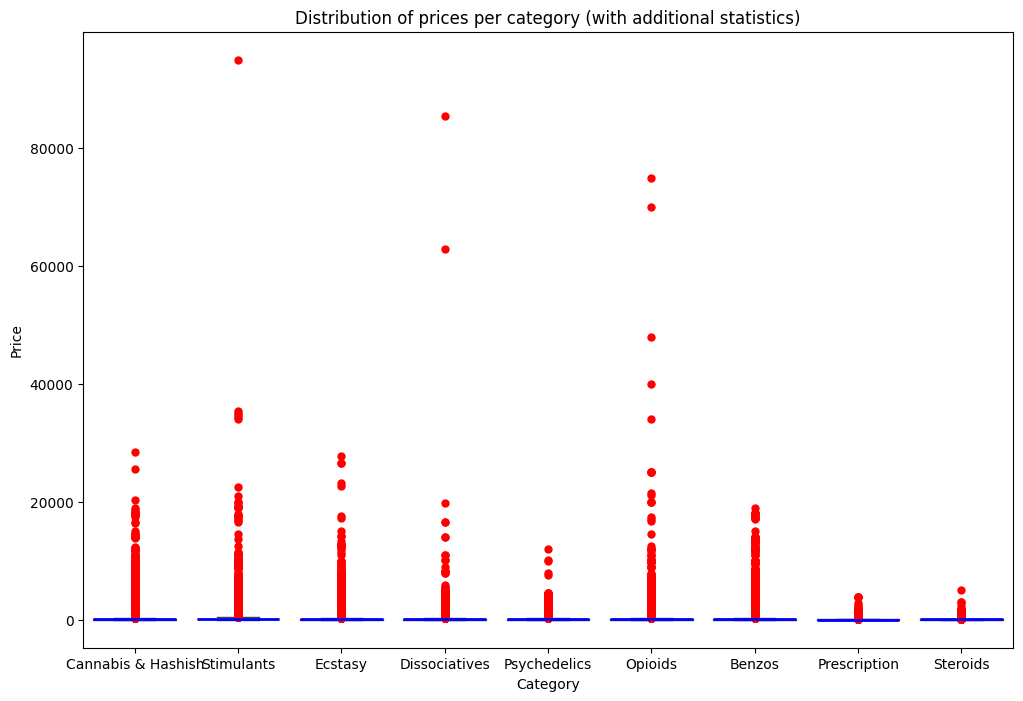

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='price', data=df, whis=1.5, showfliers=True,
            medianprops={'color': 'blue', 'linewidth': 2},
            whiskerprops={'color': 'black', 'linewidth': 1},
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red', 'markeredgecolor': 'red'})

plt.title('Distribution of prices per category (with additional statistics)')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

In [ ]:
df.loc[:,'price_quantile'] = df.groupby('category')['price'].transform(lambda x: pd.qcut(x, 4, labels=['low', 'medium-low', 'medium-high', 'high']))

In [ ]:
df[df['category']=='Benzos'][['price','price_quantile']]

,price,price_quantile
89,45.00,medium-low
91,97.00,medium-high
92,97.00,medium-high
106,48.20,medium-high
107,48.20,medium-high
...,...,...
1019747,26.00,medium-low
1019761,16.73,low
1019765,37.96,medium-low
1019795,45.00,medium-low


In [ ]:
# ab_full_drugs.to_csv(join(PROCESSED_DIR, "ab_drugs_dataset.csv"), index=False)

# Automatic Methods Prediction–Robustness Checks

To ensure good performance of automatic text methods, we follow the literature
recommendations of sampling texts so that different types of texts are represented (Japkowicz
2000). We are thus confident that our methods are well equipped to replicate manual coding
on positive, neutral and negative texts, both in terms of motive cues and text polarity.

In this section, we compare the proportions of motive cues in manually annotated AlphaBay
dataset to the proportions in feedback automatically coded by the DeBERTa model. Since we
oversample the texts following neutral and negative quantitative ratings in our sample, we
provide the comparison per rating category in Table.

In [ ]:
ab_full = pd.read_csv(join(PROCESSED_DIR, "full_dataset.csv"), encoding='latin1')
sample_prediciton = pd.read_csv(join(PROCESSED_DIR, "sample_predicted_final.csv"), encoding='latin1')

First we need to filter our main dataset:

In [ ]:
ab_relevant_feedback = ab_full[ab_full['global_id'].isin(sample_prediciton['global_id'])]

Now we can merge both dataset so we will have official rating per comements

In [ ]:
drop_col = ['m_help_other_buyer', 'm_avoid_harm_seler', 'm_help_seller',
            'm_rew_pun_seller', 'm_reach_seller', 'm_express_emo', 'm_share_facts']

sample_prediciton.drop(drop_col, axis='columns', inplace=True)

In [ ]:
sample_merge = pd.merge(sample_prediciton,
                        ab_relevant_feedback.loc[:,['global_id','rating']],
                        on='global_id')

In [ ]:
sample_merge.columns

Index(['comment', 'global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'sub_obj', 'emo_une', 'pos_neg',
       'sentiment', 'emotional', 'subjective', 'pred_sentiment',
       'pred_emotional', 'pred_subjective', 'pred_t_communication',
       'pred_t_payment', 'pred_t_refund', 'pred_t_price', 'pred_t_value',
       'pred_t_shipping', 'pred_t_product', 'pred_t_feedback', 'pred_t_vendor',
       'pred_t_generic', 'pred_t_overall', 'rating'],
      dtype='object')

## Polarity

In [ ]:
manual_shares_pol = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Positive': round((x['pos_neg'] == 'positive').mean() * 100, 1),
                         'Neutral': round((x['pos_neg'] == 'neutral').mean() * 100, 1),
                         'Negative': round((x['pos_neg'] == 'negative').mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
manual_shares_pol

,0,1,2
rating,Negative,Neutral,Positive
Positive,0.0,3.6,88.8
Neutral,4.2,57.1,7.5
Negative,95.8,39.3,3.8


In [ ]:
prediction_shares_pol = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Positive': round((x['pred_sentiment'] == 2).mean() * 100, 1),
                         'Neutral': round((x['pred_sentiment'] == 1).mean() * 100, 1),
                         'Negative': round((x['pred_sentiment'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
prediction_shares_pol

,0,1,2
rating,Negative,Neutral,Positive
Positive,0.0,10.7,90.0
Neutral,2.8,46.4,6.2
Negative,97.2,42.9,3.8


## Emotional

In [ ]:
manual_shares_emo = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Very emotional': round((x['emotional'] == 3).mean() * 100, 1),
                         'Rather emotional': round((x['emotional'] == 2).mean() * 100, 1),
                         'Somewhat emotional': round((x['emotional'] == 1).mean() * 100, 1),
                         'Unemotional': round((x['emotional'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
manual_shares_emo

,0,1,2
rating,Negative,Neutral,Positive
Very emotional,13.9,0.0,5.0
Rather emotional,52.8,71.4,32.5
Somewhat emotional,13.9,25.0,41.2
Unemotional,19.4,3.6,21.2


In [ ]:
prediction_shares_emo = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Very emotional': round((x['pred_emotional'] == 3).mean() * 100, 1),
                         'Rather emotional': round((x['pred_emotional'] == 2).mean() * 100, 1),
                         'Somewhat emotional': round((x['pred_emotional'] == 1).mean() * 100, 1),
                         'Unemotional': round((x['pred_emotional'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
prediction_shares_emo

,0,1,2
rating,Negative,Neutral,Positive
Very emotional,4.2,0.0,1.2
Rather emotional,50.0,57.1,33.8
Somewhat emotional,30.6,39.3,53.8
Unemotional,15.3,3.6,11.2


## Subjective


In [ ]:
manual_shares_sub = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Very subjective': round((x['subjective'] == 3).mean() * 100, 1),
                         'Rather subjective': round((x['subjective'] == 2).mean() * 100, 1),
                         'Somewhat subjective': round((x['subjective'] == 1).mean() * 100, 1),
                         'Objective': round((x['subjective'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
manual_shares_sub

,0,1,2
rating,Negative,Neutral,Positive
Very subjective,2.8,3.6,21.2
Rather subjective,48.6,35.7,38.8
Somewhat subjective,11.1,25.0,31.2
Objective,37.5,35.7,8.8


In [ ]:
prediction_shares_sub = (sample_merge.groupby('rating')
                     .apply(lambda x: pd.Series({
                         'Very emotional': round((x['pred_subjective'] == 3).mean() * 100, 1),
                         'Rather emotional': round((x['pred_subjective'] == 2).mean() * 100, 1),
                         'Somewhat emotional': round((x['pred_subjective'] == 1).mean() * 100, 1),
                         'Unemotional': round((x['pred_subjective'] == 0).mean() * 100, 1)
                     }))
                     .reset_index()).transpose()
prediction_shares_sub

,0,1,2
rating,Negative,Neutral,Positive
Very emotional,1.4,3.6,16.2
Rather emotional,44.4,42.9,41.2
Somewhat emotional,12.5,21.4,36.2
Unemotional,41.7,32.1,6.2


## Topics

In [ ]:
def calculate_means(df, cols, prefix=""):
    if prefix:
        cols = [prefix + col for col in cols]

    agg_dict = {col: lambda x: (x == 1).mean() * 100 for col in cols}

    result = df.groupby('rating').agg(agg_dict).round(1)
    return result

col_topic = ['t_communication', 't_payment', 't_refund',
             't_price', 't_value', 't_shipping', 't_product', 't_feedback',
             't_vendor', 't_generic', 't_overall']

# Calculate manual shares
manual_shares_topic = calculate_means(sample_merge, cols= col_topic).transpose()
# Calculate prediction shares with '_pred' suffix
prediction_shares_topic = calculate_means(sample_merge, cols= col_topic, prefix = "pred_").transpose()

In [ ]:
manual_shares_topic

rating,Negative,Neutral,Positive
t_communication,43.1,0.0,8.8
t_payment,4.2,0.0,2.5
t_refund,11.1,10.7,1.2
t_price,0.0,0.0,6.2
t_value,4.2,7.1,6.2
t_shipping,59.7,42.9,57.5
t_product,27.8,64.3,48.8
t_feedback,1.4,7.1,1.2
t_vendor,25.0,7.1,16.2
t_generic,0.0,0.0,11.2


In [ ]:
prediction_shares_topic

rating,Negative,Neutral,Positive
pred_t_communication,51.4,0.0,7.5
pred_t_payment,5.6,3.6,1.2
pred_t_refund,12.5,10.7,0.0
pred_t_price,0.0,3.6,7.5
pred_t_value,2.8,7.1,7.5
pred_t_shipping,58.3,42.9,58.8
pred_t_product,30.6,64.3,51.2
pred_t_feedback,2.8,3.6,1.2
pred_t_vendor,26.4,7.1,18.8
pred_t_generic,2.8,0.0,15.0


#Analysis of Product Categories and Comment Topics

**Research Questions:
The categories of products shapes the nature of topics discussed in comments.**

Firs we need to load our data - I will focus only 'Drugs & Chemicals' categories

In [ ]:
ab_full_drugs = pd.read_csv(join(PROCESSED_DIR,"ab_drugs_dataset.csv"), encoding='latin1')

## Multinomial logistic regression

In [ ]:
# List of topics
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value', 't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

# Subset the DataFrame
ab_drugs_topic_category = ab_full_drugs[['category'] + topics].copy()

# Clean the 'category' column by replacing special characters
ab_drugs_topic_category['category'] = ab_drugs_topic_category['category'].str.replace('&', 'and').str.replace(' ', '_')
# Convert 'category' to a categorical variable
ab_drugs_topic_category['category'] = ab_drugs_topic_category['category'].astype('category')

In [ ]:
print(ab_drugs_topic_category.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019800 entries, 0 to 1019799
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   category         1019800 non-null  category
 1   t_communication  1019800 non-null  int64   
 2   t_payment        1019800 non-null  int64   
 3   t_refund         1019800 non-null  int64   
 4   t_price          1019800 non-null  int64   
 5   t_value          1019800 non-null  int64   
 6   t_shipping       1019800 non-null  int64   
 7   t_product        1019800 non-null  int64   
 8   t_feedback       1019800 non-null  int64   
 9   t_vendor         1019800 non-null  int64   
 10  t_generic        1019800 non-null  int64   
 11  t_overall        1019800 non-null  int64   
dtypes: category(1), int64(11)
memory usage: 86.6 MB
None


Perform Multinomial Regression

In [ ]:
import statsmodels.api as sm

In [ ]:
# Prepare the independent variables (X) and the dependent variable (y)
X = ab_drugs_topic_category[topics]
y = ab_drugs_topic_category['category']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the model
try:
    model = sm.MNLogit(y, X).fit()
    # Display the summary of the model
    summary = model.summary()
    print(summary)
except Exception as e:
    print("Error fitting the model:", e)

Optimization terminated successfully.
         Current function value: 1.870394
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:               category   No. Observations:              1019800
Model:                        MNLogit   Df Residuals:                  1019704
Method:                           MLE   Df Model:                           88
Date:                Tue, 18 Jun 2024   Pseudo R-squ.:                 0.01718
Time:                        00:13:12   Log-Likelihood:            -1.9074e+06
converged:                       True   LL-Null:                   -1.9408e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
category=Cannabis_and_Hashish       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.3213      0.009    140.739      0.

In [ ]:
#Creating a DataFrame from the model table
df_model_summary = pd.DataFrame(model.summary().tables[1].data[1:],
                                columns=model.summary().tables[1].data[0])

# Extracting the first category from the header
current_category = df_model_summary.columns[0].split('=')[1].strip()

# Transforming the columns to contain the correct headers
df_model_summary.columns = ['topic'] + list(df_model_summary.columns[1:])


rows = []
# Coverting rows
for index, row in df_model_summary.iterrows():
    if 'category=' in row['topic']:
        current_category = row['topic'].split('=')[1].strip()
    else:
        row['category'] = current_category
        rows.append(row)

data_to_plot = pd.DataFrame(rows)
data_to_plot.reset_index(drop=True, inplace=True)

In [ ]:
topic_mapping = {
    't_communication': 'Communication',
    't_payment': 'Payment / finalise early',
    't_refund': 'Refunds',
    't_price': 'Extras / goodies',
    't_value': 'Value for money',
    't_shipping': 'Delivery / stealth',
    't_product': 'Product quality',
    't_feedback': 'Leaving / changing feedback',
    't_vendor': 'Vendor quality',
    't_generic': 'Generic rating',
    't_overall': 'Overall experience',
    'const': 'Intercept'
}

data_to_plot['topic'] = data_to_plot['topic'].map(topic_mapping)
data_to_plot['category'] = data_to_plot['category'].replace({'Cannabis_and_Hashish': 'Cannabis & Hashish'})


In [ ]:
data_to_plot.head()

,topic,coef,std err,z,P>|z|,[0.025,0.975],category,probability,error
0,Intercept,1.3213,0.009,140.739,0.0,1.303,1.340,Cannabis & Hashish,0.789398,0.001496
1,Communication,-0.2008,0.018,-11.300,0.0,-0.236,-0.166,Cannabis & Hashish,0.449968,0.004455
2,Payment / finalise early,-0.0772,0.022,-3.538,0.0,-0.120,-0.034,Cannabis & Hashish,0.480710,0.005492
3,Refunds,0.9671,0.073,13.209,0.0,0.824,1.111,Cannabis & Hashish,0.724541,0.014569
4,Extras / goodies,-1.1819,0.015,-81.429,0.0,-1.210,-1.153,Cannabis & Hashish,0.234711,0.002694


In [ ]:
# Convert columns to numeric types
data_to_plot['coef'] = data_to_plot['coef'].astype(float)
data_to_plot['std err'] = data_to_plot['std err'].astype(float)
data_to_plot['P>|z|'] = data_to_plot['P>|z|'].astype(float)

# Calculate probabilities
data_to_plot['probability'] = np.exp(data_to_plot['coef']) / (1 + np.exp(data_to_plot['coef']))
# Calculate standard errors for probabilities
data_to_plot['error'] = data_to_plot['std err'] * data_to_plot['probability'] * (1 - data_to_plot['probability'])

In [ ]:
data_to_plot.dtypes

topic           object
coef           float64
std err        float64
z               object
P>|z|          float64
[0.025          object
0.975]          object
category        object
probability    float64
error          float64
dtype: object

Save data to create graphs in R:


In [ ]:
data_to_plot.to_csv(join(PROJECT_DIR, "Results/mlogit_topic_category.csv"), index=False)

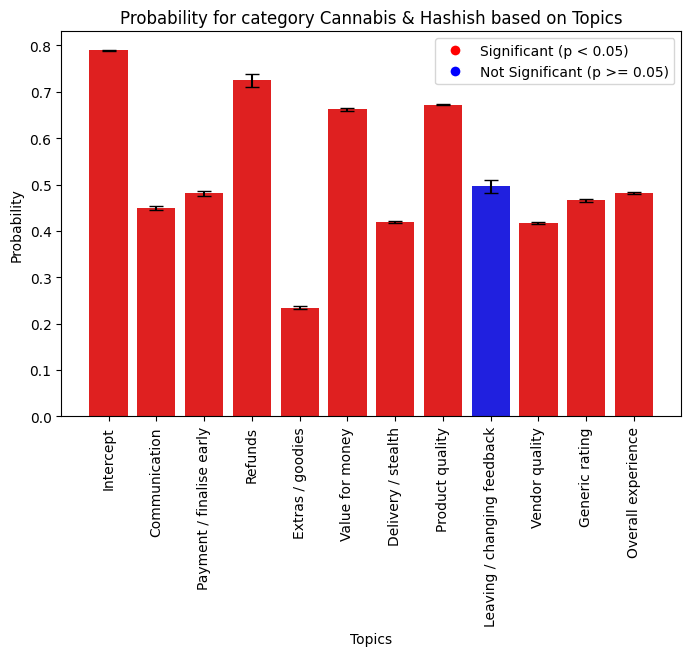

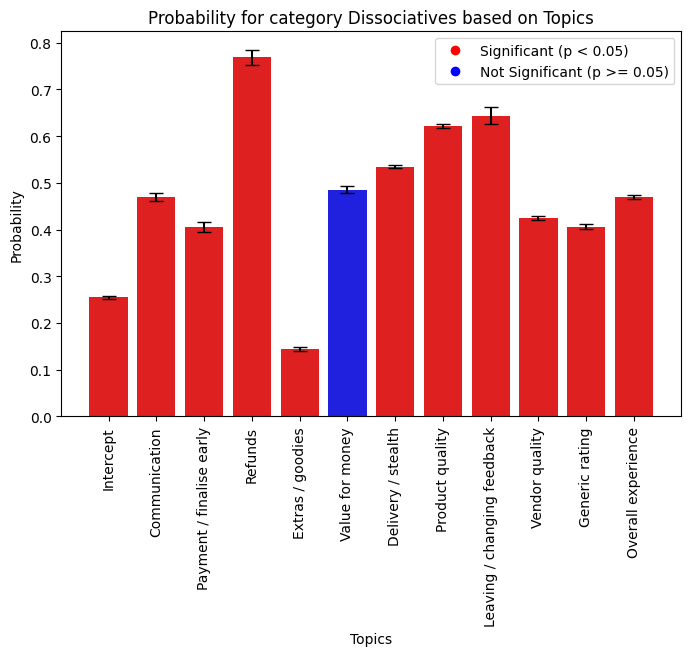

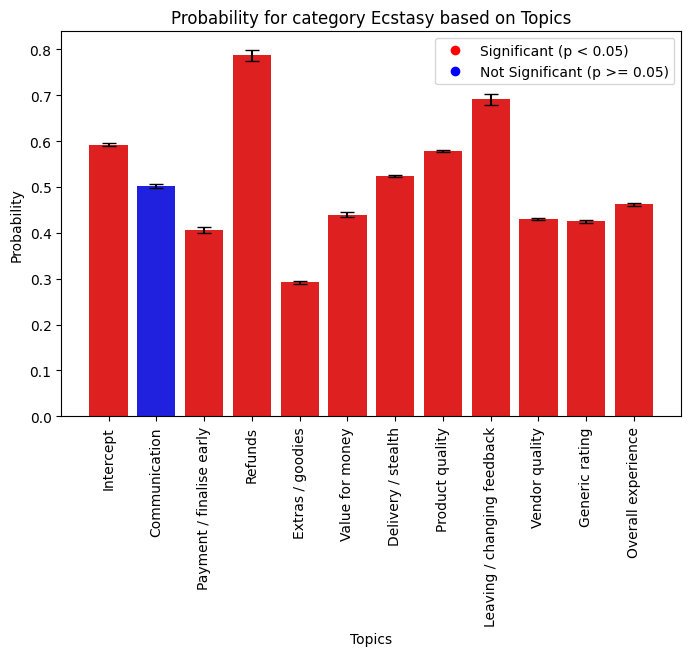

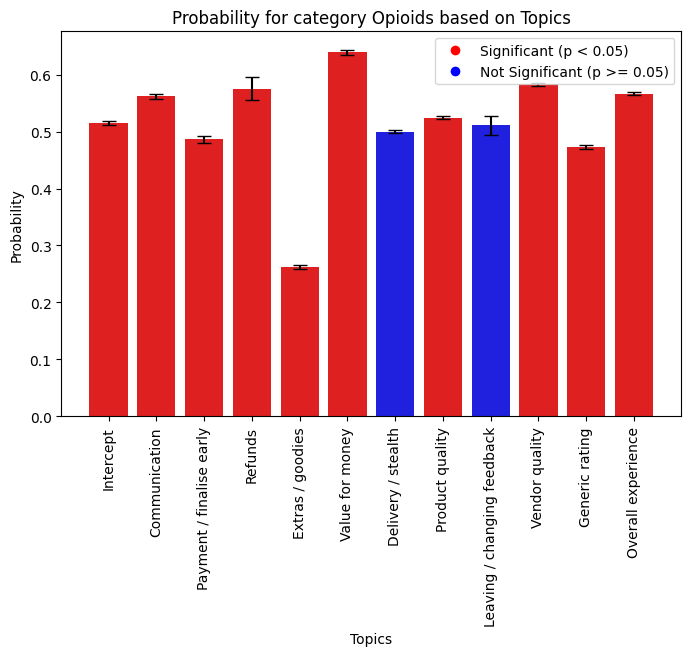

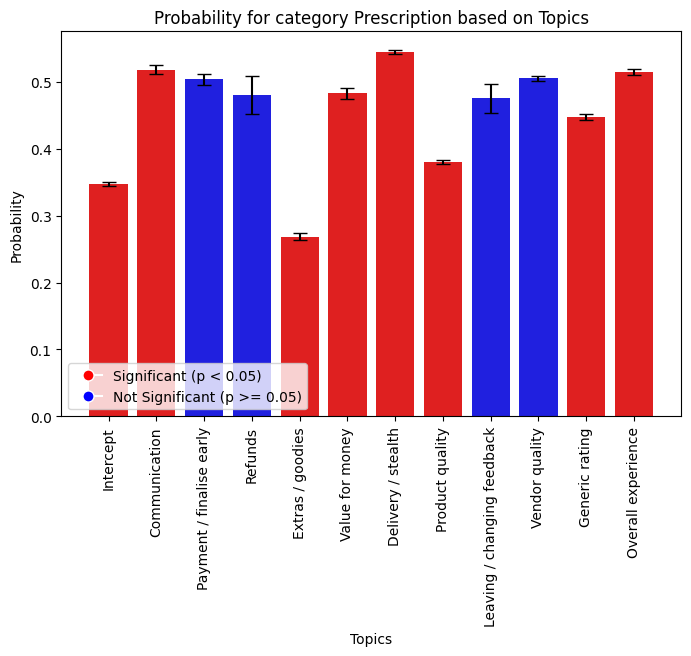

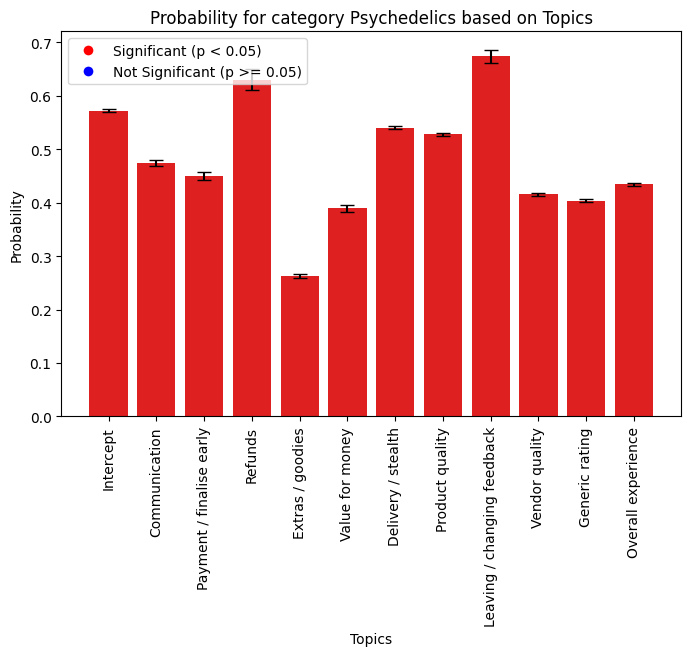

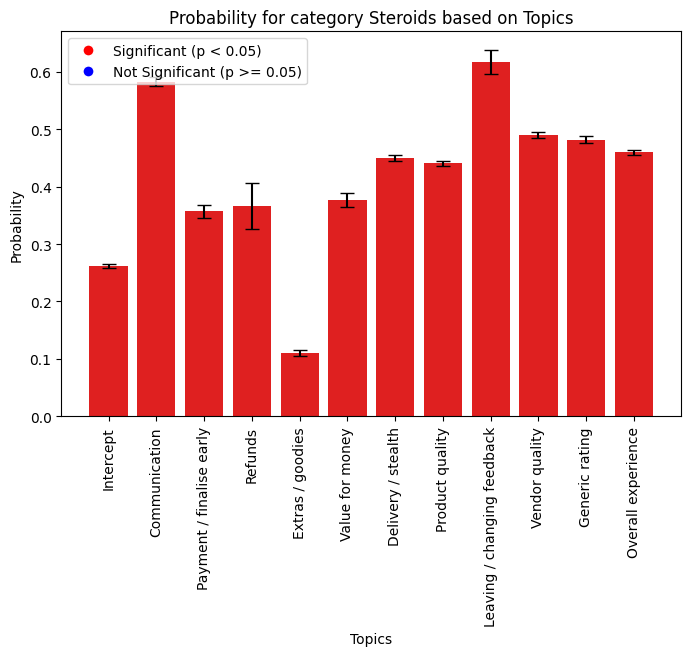

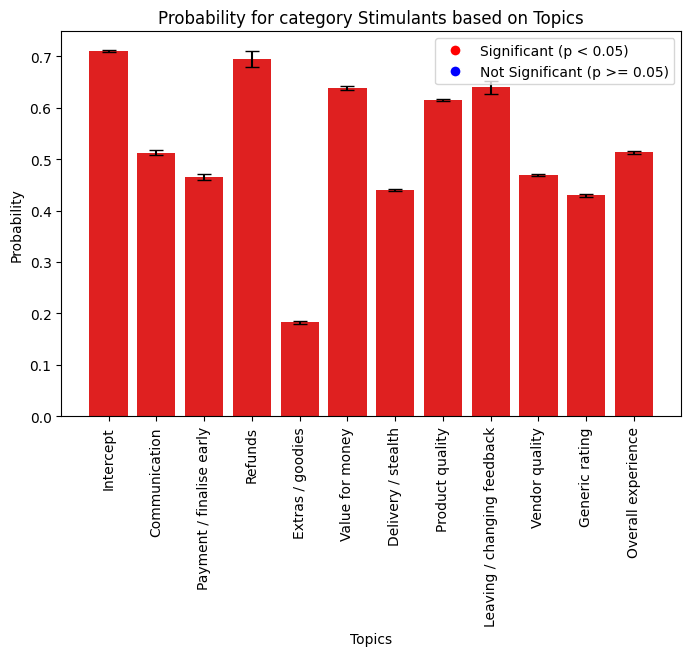

In [ ]:
#  Function to plot probabilities for a given category
def plot_category_probabilities(df, category):
    category_data = df[df['category'] == category]

    # Create a list of colors to highlight significant topics
    colors = ['red' if p < 0.05 else 'blue' for p in category_data['P>|z|']]

    plt.figure(figsize=(8, 5))
    bars = sns.barplot(x='topic', y='probability', data=category_data, hue='topic', palette=dict(zip(category_data['topic'], colors)), dodge=False, errorbar=None)
    plt.errorbar(x=np.arange(len(category_data['topic'])), y=category_data['probability'], yerr=category_data['error'], fmt='none', c='black', capsize=5)

    plt.xlabel('Topics')
    plt.ylabel('Probability')
    plt.title(f'Probability for category {category} based on Topics')
    plt.xticks(rotation=90)

    # Manually add a legend for significance
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Significant (p < 0.05)')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Not Significant (p >= 0.05)')
    plt.legend(handles=[red_patch, blue_patch])

    plt.show()

# Generate plots for each category
categories = data_to_plot['category'].unique()
for category in categories:
    plot_category_probabilities(data_to_plot, category)

## Chi-square test

In [ ]:
# List of topics
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value', 't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

# Chi-square test results for each pair (category, topic)
chi2_results = {}

for topic in topics:
    # Contingency table
    contingency_table = pd.crosstab(ab_full_drugs['category'], ab_full_drugs[topic])

    # Chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    # Store results
    chi2_results[topic] = {'chi2': chi2, 'p-value': p, 'dof': dof}

chi2_results_df = pd.DataFrame(chi2_results).T

In [ ]:
chi2_results_df

,chi2,p-value,dof
t_communication,2531.227303,0.000000e+00,8.0
t_payment,621.303503,6.145108e-129,8.0
t_refund,942.371104,4.082324e-198,8.0
t_price,10261.190320,0.000000e+00,8.0
t_value,10879.065690,0.000000e+00,8.0
t_shipping,5879.840643,0.000000e+00,8.0
t_product,22928.033431,0.000000e+00,8.0
t_feedback,1172.848003,7.046925e-248,8.0
t_vendor,9957.968221,0.000000e+00,8.0
t_generic,1365.598093,1.551597e-289,8.0


All topics have very low p-values, suggesting that for all of these topics there is a statistically significant relationship between the product category and the topic being discussed.

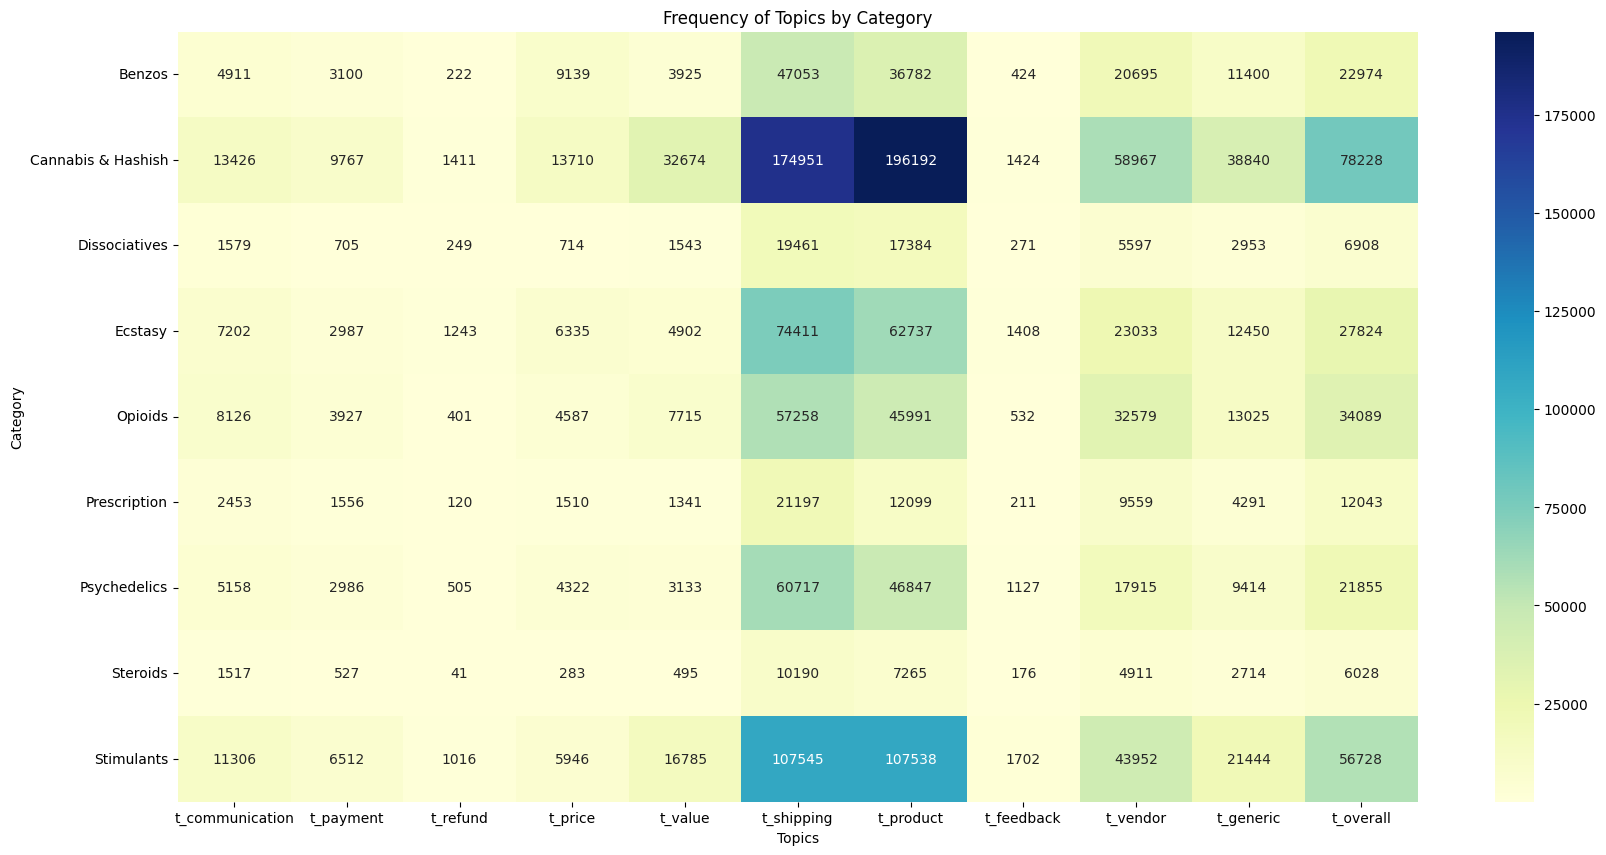

In [ ]:
# Topic columns
topic_columns = ['t_communication', 't_payment', 't_refund', 't_price', 't_value',
                 't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

# Frequency analysis
frequency_table = ab_full_drugs.groupby('category')[topic_columns].sum()
frequency_table = frequency_table.round().astype(int)

# Frequency visualization
plt.figure(figsize=(20, 10))
sns.heatmap(frequency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequency of Topics by Category')
plt.xlabel('Topics')
plt.ylabel('Category')
plt.show()

## Logistic regression

In [ ]:
ab_full_drugs_lr = ab_full_drugs
ab_full_drugs_lr = pd.get_dummies(ab_full_drugs, columns=['category'], drop_first=True)

ab_full_drugs_lr.rename(columns={'category_Cannabis & Hashish': 'category_Cannabis'}, inplace=True)

# List of topics
topic_columns = ['t_communication', 't_payment', 't_refund', 't_price', 't_value', 't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']

# Initialize an empty DataFrame to store results
all_results = pd.DataFrame()

for topic in topic_columns:
    formula = f"{topic} ~ " + " + ".join([col for col in ab_full_drugs_lr.columns if col.startswith('category_')])
    model = logit(formula, data=ab_full_drugs_lr).fit()

    # Get the summary table
    summary_table = model.summary2().tables[1]

    # Add a new column with the topic name
    summary_table['topic'] = topic

    # Append the results to the all_results DataFrame
    all_results = pd.concat([all_results, summary_table])

all_results.reset_index(inplace=True)


Optimization terminated successfully.
         Current function value: 0.210616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031640
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.181310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.041814
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.513242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354682
 

In [ ]:
all_results

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],topic
0,Intercept,-2.764705,0.014712,-187.917964,0.000000e+00,-2.793541,-2.735870,t_communication
1,category_Cannabis[T.True],-0.378071,0.017151,-22.043973,1.091281e-107,-0.411686,-0.344456,t_communication
2,category_Dissociatives[T.True],-0.147865,0.029735,-4.972760,6.600638e-07,-0.206145,-0.089586,t_communication
3,category_Ecstasy[T.True],0.015569,0.019084,0.815825,4.146002e-01,-0.021834,0.052972,t_communication
4,category_Opioids[T.True],0.287551,0.018704,15.373570,2.462196e-53,0.250891,0.324211,t_communication
...,...,...,...,...,...,...,...,...
94,category_Opioids[T.True],0.227419,0.010182,22.334301,1.715936e-110,0.207462,0.247376,t_overall
95,category_Prescription[T.True],0.203201,0.013501,15.050472,3.427819e-51,0.176739,0.229663,t_overall
96,category_Psychedelics[T.True],-0.275012,0.010923,-25.177531,7.060894e-140,-0.296420,-0.253603,t_overall
97,category_Steroids[T.True],0.106716,0.017231,6.193184,5.896097e-10,0.072943,0.140488,t_overall


Change formating

In [ ]:
all_results = all_results.round({'Coef.': 4, 'Std.Err.': 4, 'z': 4, '[0.025': 4, '0.975]': 4})
all_results['P>|z|'] = all_results['P>|z|'].astype(float)

all_results['P>|z|'] = all_results['P>|z|'].round(3)

In [ ]:
all_results

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],topic
0,Intercept,-2.7647,0.0147,-187.9180,0.000,-2.7935,-2.7359,t_communication
1,category_Cannabis[T.True],-0.3781,0.0172,-22.0440,0.000,-0.4117,-0.3445,t_communication
2,category_Dissociatives[T.True],-0.1479,0.0297,-4.9728,0.000,-0.2061,-0.0896,t_communication
3,category_Ecstasy[T.True],0.0156,0.0191,0.8158,0.415,-0.0218,0.0530,t_communication
4,category_Opioids[T.True],0.2876,0.0187,15.3736,0.000,0.2509,0.3242,t_communication
...,...,...,...,...,...,...,...,...
94,category_Opioids[T.True],0.2274,0.0102,22.3343,0.000,0.2075,0.2474,t_overall
95,category_Prescription[T.True],0.2032,0.0135,15.0505,0.000,0.1767,0.2297,t_overall
96,category_Psychedelics[T.True],-0.2750,0.0109,-25.1775,0.000,-0.2964,-0.2536,t_overall
97,category_Steroids[T.True],0.1067,0.0172,6.1932,0.000,0.0729,0.1405,t_overall


In [ ]:
all_results.to_csv('logistic.csv')

In [ ]:
results_significant = all_results[all_results['P>|z|'] < 0.05]
results_significant

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],topic
0,Intercept,-2.7647,0.0147,-187.9180,0.0,-2.7935,-2.7359,t_communication
1,category_Cannabis[T.True],-0.3781,0.0172,-22.0440,0.0,-0.4117,-0.3445,t_communication
2,category_Dissociatives[T.True],-0.1479,0.0297,-4.9728,0.0,-0.2061,-0.0896,t_communication
4,category_Opioids[T.True],0.2876,0.0187,15.3736,0.0,0.2509,0.3242,t_communication
5,category_Prescription[T.True],0.1006,0.0255,3.9372,0.0,0.0505,0.1506,t_communication
...,...,...,...,...,...,...,...,...
93,category_Ecstasy[T.True],-0.2370,0.0103,-22.9054,0.0,-0.2573,-0.2167,t_overall
94,category_Opioids[T.True],0.2274,0.0102,22.3343,0.0,0.2075,0.2474,t_overall
95,category_Prescription[T.True],0.2032,0.0135,15.0505,0.0,0.1767,0.2297,t_overall
96,category_Psychedelics[T.True],-0.2750,0.0109,-25.1775,0.0,-0.2964,-0.2536,t_overall


Topic: t_communication

For the topic of communication, the intercept coefficient is -2.7647, which is highly significant with a p-value of 0.000. This indicates a strong negative baseline effect on the outcome variable when all other predictors are zero. Among the variables within this topic, the variable Cannabis has a coefficient of -0.3781, suggesting that communications related to cannabis are associated with a significantly lower likelihood of the outcome, supported by a highly significant p-value of 0.000. Similarly, Dissociatives have a coefficient of -0.1479 and are also highly significant (p-value 0.000), indicating a negative association with the outcome. On the other hand, Ecstasy, with a coefficient of 0.0156, shows a slight positive association but is not statistically significant (p-value 0.415). Lastly, Opioids have a positive coefficient of 0.2876, indicating that communications related to opioids are associated with a higher likelihood of the outcome, and this variable is highly significant with a p-value of 0.000.

Topic: t_feedback

Within the topic of feedback, the intercept is significantly positive with a coefficient of -2.7647 and a p-value of 0.000. Feedback related to Cannabis shows a negative coefficient of -0.2223, indicating a lower likelihood of the outcome with a highly significant p-value. Dissociatives have a coefficient of -0.2461, suggesting a negative association, while Ecstasy's coefficient of 0.2154 indicates a positive association. Both variables are highly significant. Opioids, with a coefficient of 0.5362, show a strong positive association with the outcome and are highly significant.


Summary

The analysis reveals that different categories within each topic have varying impacts on the likelihood of the outcome. Generally, Cannabis tends to have a negative association across most topics, while Opioids often show a positive association. The significance levels (p-values) indicate that most of these associations are statistically significant, providing robust insights into the factors influencing the outcome.

##  Correspondence Analysis

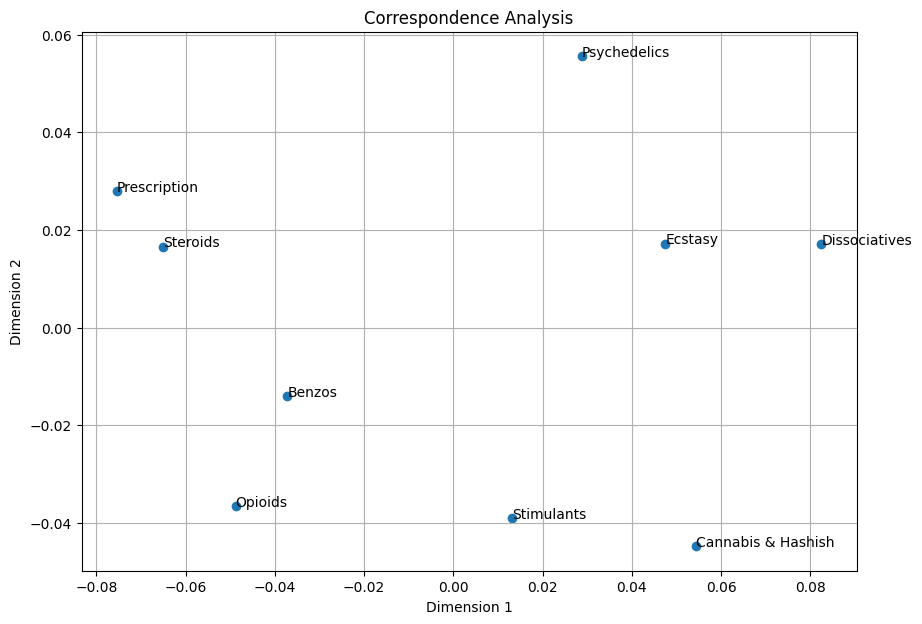

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(ab_full_drugs['category'], [ab_full_drugs['t_communication'], ab_full_drugs['t_payment'], ab_full_drugs['t_refund'],
                                                            ab_full_drugs['t_price'], ab_full_drugs['t_value'], ab_full_drugs['t_shipping'],
                                                            ab_full_drugs['t_product'], ab_full_drugs['t_feedback'], ab_full_drugs['t_vendor'],
                                                            ab_full_drugs['t_generic'], ab_full_drugs['t_overall']])

# Perform Correspondence Analysis using PCA on the standardized contingency table
pca = PCA(n_components=2)
contingency_table_standardized = contingency_table.div(contingency_table.sum(axis=1), axis=0)  # Normalize rows
coordinates = pca.fit_transform(contingency_table_standardized)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(coordinates[:, 0], coordinates[:, 1])

# Annotate points with category names
for i, category in enumerate(contingency_table.index):
    plt.annotate(category, (coordinates[i, 0], coordinates[i, 1]))

plt.title('Correspondence Analysis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

Cannabis & Hashish, Stimulants, and Opioids: These categories are relatively close to each other on Dimension 1, suggesting that they have similar comment profiles. For example, they may have a similar percentage of comments about price, shipping, etc.

Psychedelics: This category is clearly separated on Dimension 2, suggesting that its comment profile is different from other categories.

Ecstasy and Dissociatives: These categories are close to each other, suggesting a similarity in comment profiles.

# Shares of topics occurrences per quantitative feedback rating

**Research question: Are there any feedback topics that are predominantly associated with negative ratings?**

**Only rating**


Calculation of percentages for each rating category within each thematic column

In [ ]:
topics = ['t_communication', 't_payment', 't_refund', 't_price', 't_value',
          't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic', 't_overall']
df_topic_share = ab_full_drugs[['rating'] + topics]

# Grouping data by 'rating' and summing the topics
grouped_sum = df_topic_share.groupby('rating').sum()

# Calculating the percentage share for each topic
total_sum = grouped_sum.sum()
percentage_shares = grouped_sum.div(total_sum, axis=1) * 100
percentage_shares_reset = percentage_shares.reset_index()

# Melting the DataFrame to get a long format
percentage_shares_long = percentage_shares_reset.melt(id_vars=['rating'], var_name='topic', value_name='share')
percentage_shares_long['share'] = percentage_shares_long['share'].round(2)

topic_mapping = {
    't_communication': 'Communication',
    't_payment': 'Payment / finalise early',
    't_refund': 'Refunds',
    't_price': 'Extras / goodies',
    't_value': 'Value for money',
    't_shipping': 'Delivery / stealth',
    't_product': 'Product quality',
    't_feedback': 'Leaving / changing feedback',
    't_vendor': 'Vendor quality',
    't_generic': 'Generic rating',
    't_overall': 'Overall experience'
}

percentage_shares_long['topic'] = percentage_shares_long['topic'].map(topic_mapping)

Let's calculate the average share for different topics (such as communication, payments, etc.) and express them as percentages. It won't add up to 100% here.

In [ ]:
def calculate_percentage(x):
    return x.mean() * 100

overall_values = {
    'Communication': calculate_percentage(ab_full_drugs['t_communication']),
    'Payment / finalise early': calculate_percentage(ab_full_drugs['t_payment']),
    'Refunds': calculate_percentage(ab_full_drugs['t_refund']),
    'Extras / goodies': calculate_percentage(ab_full_drugs['t_price']),
    'Value for money': calculate_percentage(ab_full_drugs['t_value']),
    'Delivery / stealth': calculate_percentage(ab_full_drugs['t_shipping']),
    'Product quality': calculate_percentage(ab_full_drugs['t_product']),
    'Leaving / changing feedback': calculate_percentage(ab_full_drugs['t_feedback']),
    'Vendor quality': calculate_percentage(ab_full_drugs['t_vendor']),
    'Generic rating': calculate_percentage(ab_full_drugs['t_generic']),
    'Overall experience': calculate_percentage(ab_full_drugs['t_overall'])
}

# Convert overall values to a DataFrame
overall_values_df = pd.DataFrame(overall_values.items(), columns=['topic', 'share'])
overall_values_df['rating'] = 'All'

# Reorder columns to match the original table format
overall_values_df = overall_values_df[['rating', 'topic', 'share']]

# Round values
overall_values_df['share'] = round(overall_values_df['share'], 1)

**Rating and emotion**

Function to calculate percentage shares for each topic, rating, and emotional value


In [ ]:
# Function to calculate percentage shares for each topic, rating, and emotional value
def calculate_percentage(df, topics):
    results = []

    # Total count of the entire dataset
    total_count_all = len(df)

    # Iterate through each topic
    for topic in topics:
        # Overall percentage for the entire dataset
        total_count_topic = df[topic].sum()
        percentage_all_total = (total_count_topic / total_count_all) * 100
        results.append([topic, 'ALL', 'All', percentage_all_total])

        # Group data by 'rating' and calculate count for the current topic
        grouped_all = df.groupby('rating')[topic].sum()

        # Calculate percentage share for each rating for the entire dataset
        for rating, count in grouped_all.items():
            total_count_rating_all = df[df['rating'] == rating][topic].sum()
            percentage_rating_all = (count / total_count_topic) * 100
            results.append([topic, 'ALL', rating, percentage_rating_all])

        # Iterate through emotional values (0 and 1)
        for emotional_value in [0, 1]:
            # Filter data for the current emotional value
            filtered_df = df[df['emotional'] == emotional_value]

            # Total count for the current emotional value
            total_count_emotional = len(filtered_df)

            # Total count for the current topic and emotional value
            total_count_topic_emotional = filtered_df[topic].sum()
            percentage_all_emotional = (total_count_topic_emotional / total_count_emotional) * 100
            results.append([topic, emotional_value, 'All', percentage_all_emotional])

            # Group data by 'rating' and calculate count for the current topic
            grouped = filtered_df.groupby('rating')[topic].sum()

            # Calculate percentage share for each rating
            for rating, count in grouped.items():
                total_count_rating = filtered_df[filtered_df['rating'] == rating][topic].sum()
                percentage_rating = (count / total_count_topic_emotional) * 100
                results.append([topic, emotional_value, rating, percentage_rating])

    # Create a DataFrame from the results list
    final_result = pd.DataFrame(results, columns=['topic', 'emotional', 'rating', 'share'])

    return final_result

# Calculate percentage shares for the given DataFrame and topics
percentage_shares_emotion = calculate_percentage(ab_full_drugs[['rating', 'emotional'] + topics], topics)

percentage_shares_emotion = percentage_shares_emotion.round(2)
percentage_shares_emotion['topic'] = percentage_shares_emotion['topic'].map(topic_mapping)
percentage_shares_emotion['emotional'] = percentage_shares_emotion['emotional'].replace({0: 'Unemotional',
                                                                                         1: 'Emotional',
                                                                                         'ALL': 'ALL'})
percentage_shares_emotion.head()

,topic,emotional,rating,share
0,Communication,ALL,All,5.46
1,Communication,ALL,Negative,12.98
2,Communication,ALL,Neutral,3.71
3,Communication,ALL,Positive,83.31
4,Communication,Unemotional,All,5.90


In [ ]:
percentage_shares_emotion[percentage_shares_emotion['topic']=='Communication']

,topic,emotional,rating,share
0,Communication,ALL,All,5.46
1,Communication,ALL,Negative,12.98
2,Communication,ALL,Neutral,3.71
3,Communication,ALL,Positive,83.31
4,Communication,Unemotional,All,5.90
5,Communication,Unemotional,Negative,9.79
6,Communication,Unemotional,Neutral,1.76
7,Communication,Unemotional,Positive,88.45
8,Communication,Emotional,All,4.63
9,Communication,Emotional,Negative,20.71


Save the data to visualize them better in R:

In [ ]:
percentage_shares_emotion.to_csv(join(PROJECT_DIR, "Results/df_shares_topic.csv"), index=False)

Visualization:

In [ ]:
# Define the order for rating and topics
rating_order = ['All', 'Positive', 'Neutral', 'Negative']

topic_order = ['Communication', 'Payment / finalise early', 'Refunds', 'Extras / goodies',
                 'Value for money', 'Delivery / stealth', 'Product quality', 'Leaving / changing feedback',
                 'Vendor quality', 'Generic rating', 'Overall experience']

# Get unique values for topics and emotional states
topics = percentage_shares_emotion['topic'].unique()
emotional_states = percentage_shares_emotion['emotional'].unique()

palette = ["#4C72B0", "#E08283",  "#F5C242", "#55A868",]

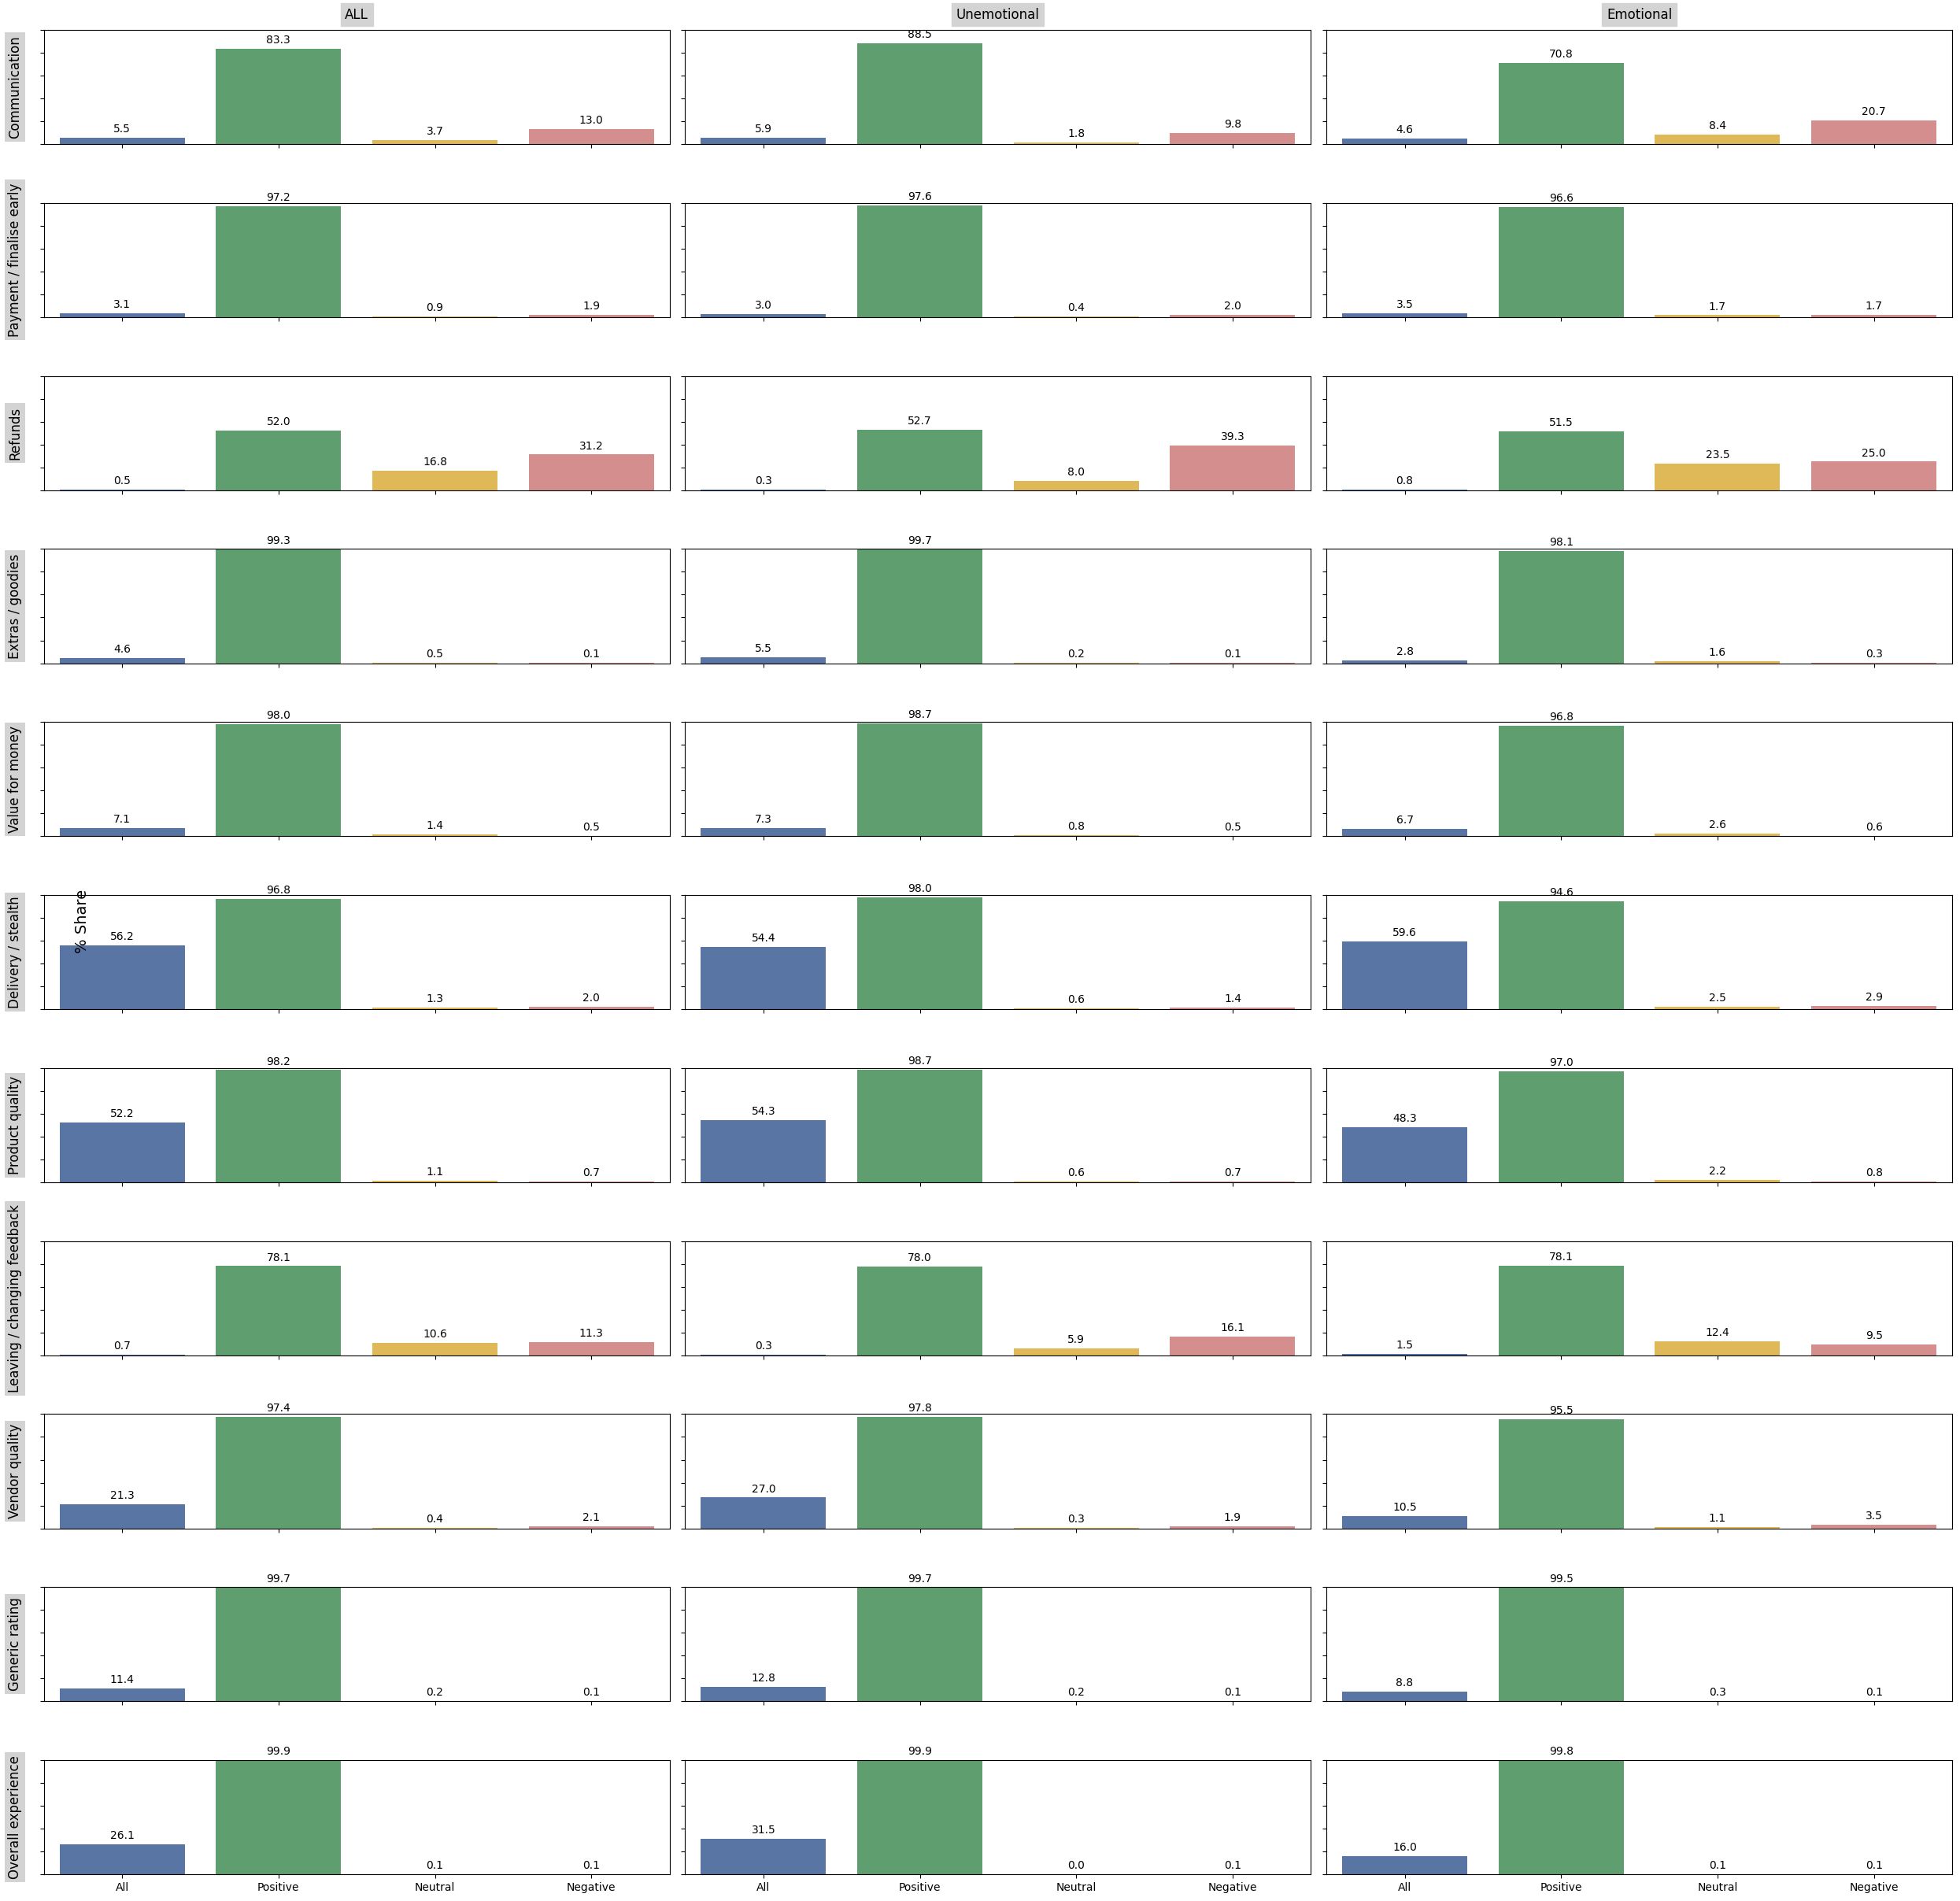

In [ ]:
# Create the necessary number of subplots with improved layout and data representation
fig, axes = plt.subplots(len(topic_order), len(emotional_states), figsize=(25, 25), sharey=True, sharex=True)

# Plot each combination
for i, topic in enumerate(topic_order):
    for j, emotional in enumerate(emotional_states):
        ax = axes[i, j]
        data = percentage_shares_emotion[(percentage_shares_emotion['topic'] == topic) & (percentage_shares_emotion['emotional'] == emotional)]
        if not data.empty:
            sns.barplot(x='rating', y='share', data=data, ax=ax, palette=palette, hue='rating', dodge=False, order=rating_order)
        else:
            # Create a DataFrame with zero values if data is empty
            empty_data = pd.DataFrame({
                'rating': ['All', 'Positive', 'Neutral', 'Negative'],
                'share': [0, 0, 0, 0]
            })
            sns.barplot(x='rating', y='share', data=empty_data, ax=ax, palette=palette, hue='rating', dodge=False, order=rating_order)
        ax.set_ylim(0, 100)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Adding value labels on top of the bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

        if j == 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            # Add rotated topic name in grey box
            ax.annotate(topic, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90,
                        bbox=dict(facecolor='lightgrey', edgecolor='none', pad=3))
        if i == 0:
            ax.set_title(emotional, fontsize=12, color='black', backgroundcolor='lightgrey', pad=10)

# Set common X and Y labels
fig.text(0.04, 0.5, '% Share', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure labels and titles are clear
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

## Shares of topic by rating

This time we check shares of topic by rating in whole dataset. So the percentage of each individual ratings dont sum to a 100%

In [ ]:
def calculate_percentage(x):
    return x.mean() * 100

barpred_or_cues = ab_full_drugs.groupby(['rating']).agg(
    **{
        'Communication': ('t_communication', calculate_percentage),
        'Payment / finalise early': ('t_payment', calculate_percentage),
        'Refunds': ('t_refund', calculate_percentage),
        'Extras / goodies': ('t_price', calculate_percentage),
        'Value for money': ('t_value', calculate_percentage),
        'Delivery / stealth': ('t_shipping', calculate_percentage),
        'Product quality': ('t_product', calculate_percentage),
        'Leaving / changing feedback': ('t_feedback', calculate_percentage),
        'Vendor quality': ('t_vendor', calculate_percentage),
        'Generic rating': ('t_generic', calculate_percentage),
        'Overall experienc': ('t_overall', calculate_percentage)
    })

# convert to long format
barpred_or_cues_long = (barpred_or_cues.reset_index()
                         .melt(id_vars=['rating'], var_name='topic', value_name='share'))

# round values
barpred_or_cues_long['share'] = round(barpred_or_cues_long['share'], 1)

In [ ]:
final_rating_type = pd.concat([barpred_or_cues_long, overall_values_df], ignore_index=True)

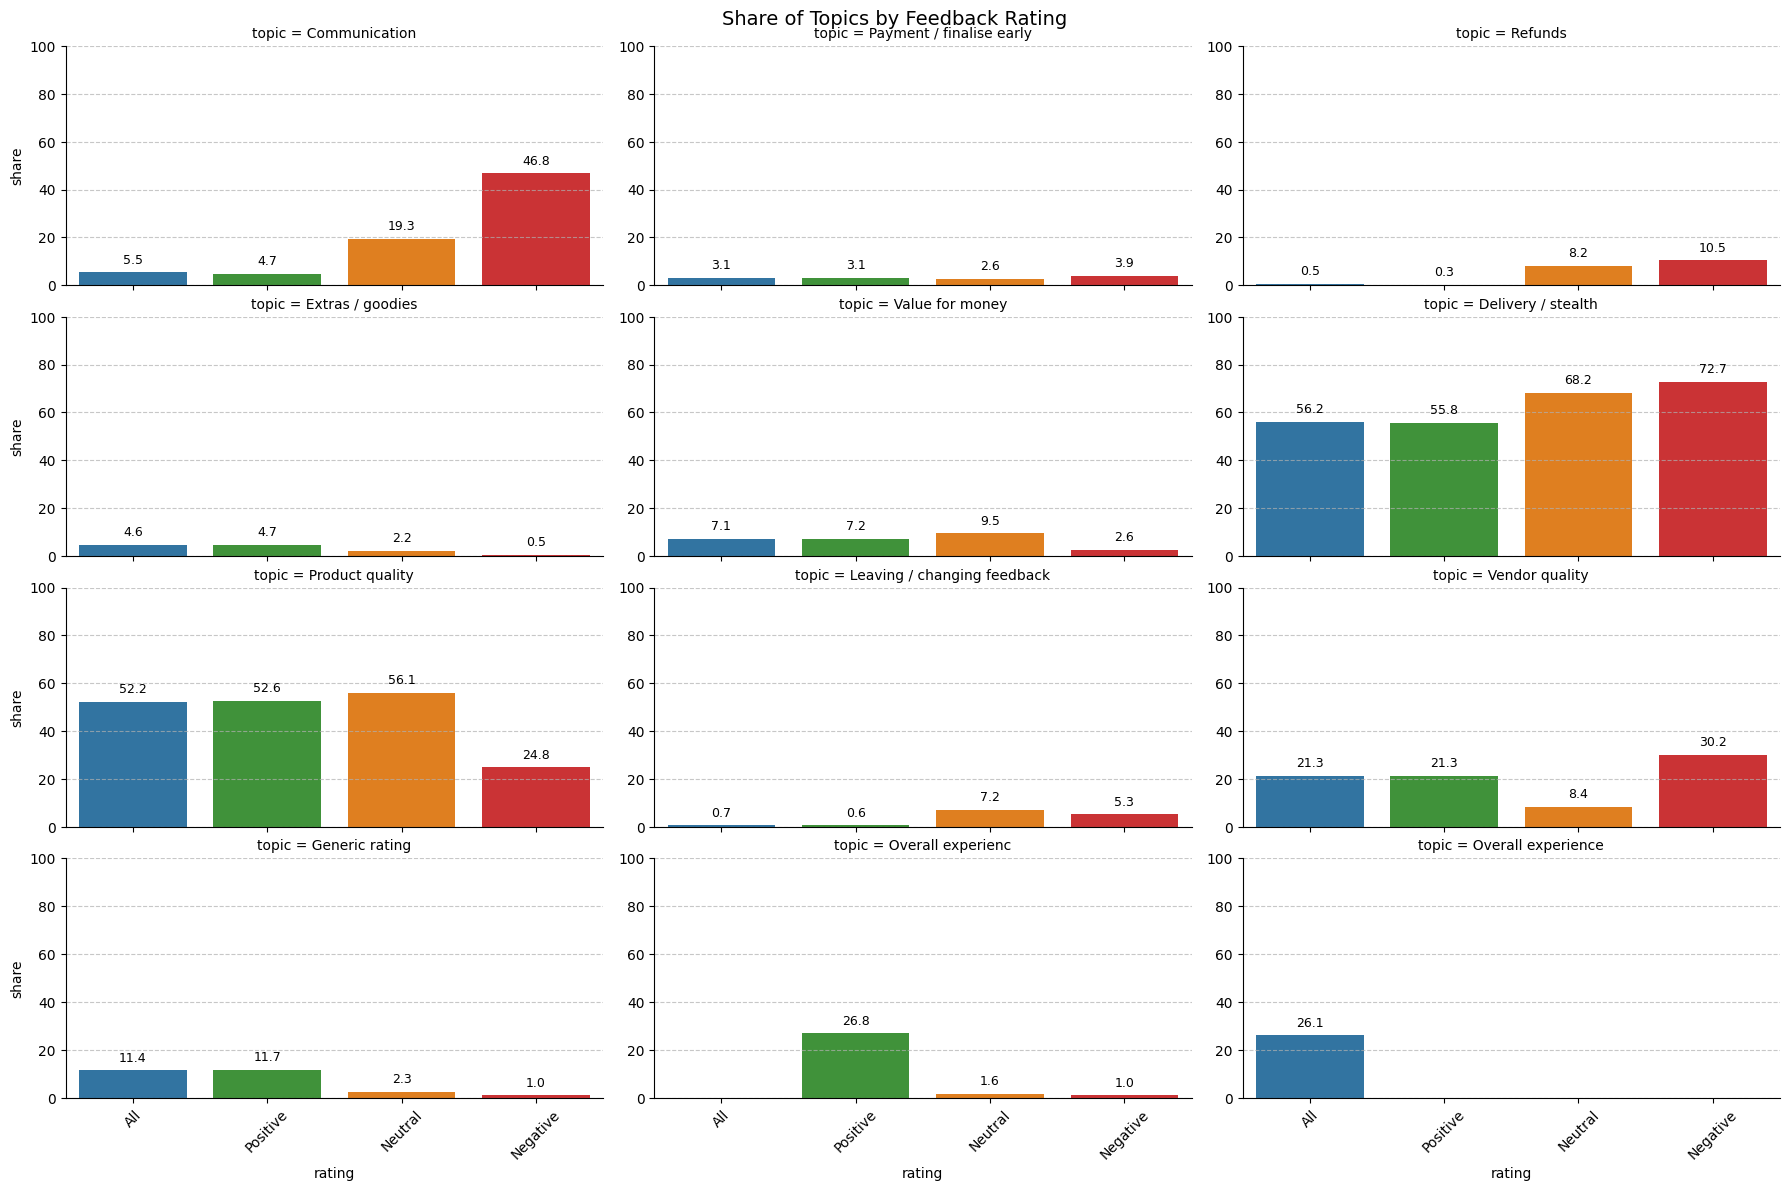

In [ ]:
# Define the order of the categories
rating_order = ["All", "Positive", "Neutral", "Negative"]
final_rating_type['rating'] = pd.Categorical(final_rating_type['rating'], categories=rating_order, ordered=True)

# Set the color palette
palette = {"All": "#1F78B4", "Positive": "#33A02C", "Neutral": "#FF7F00", "Negative": "#E31A1C"}

# Create the FacetGrid for each topic
g = sns.FacetGrid(final_rating_type, col="topic", hue="rating", col_wrap=3, sharey=False, palette=palette, height=4, aspect=1.5)

# Map the barplot to the FacetGrid
g.map(sns.barplot, "rating", "share", order=rating_order)

# Customize the plot
g.set(ylim=(0, 100))  # Adjust the ylim value

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.subplots_adjust(top=1)
g.fig.suptitle('Share of Topics by Feedback Rating', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(bottom=0.3)  # Adjust bottom to make space for the legend


# Show the plot
plt.show()

# Mixed-Effects Models

In [ ]:
df = ab_full_drugs

Definiction of Mixed model

In [ ]:
df.columns

Index(['seller', 'date_left', 'comment', 'itemid', 'price', 'rating',
       'category', 'global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'pos_neg', 'emo_une', 'sub_obj',
       'origin', 'name', 'class', 'payment', 'cat1', 'cat2', 'cat3', 'date_le',
       'n_sold', 'since', 'vendor_level', 'trust_level', 'shipping_category',
       'quartile', 'price_quantile', 'log_price'],
      dtype='object')

In [ ]:

# Log transformation
df['log_price'] = np.log1p(df['price'])

# Mixed model with original price
model1 = smf.mixedlm("emotional ~ price", df, groups=df["category"]).fit()
print(model1.summary())

# Mixed model with log-transformed price
model2 = smf.mixedlm("emotional ~ log_price", df, groups=df["category"]).fit()
print(model2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: emotional   
No. Observations: 1019800  Method:             REML        
No. Groups:       9        Scale:              0.2250      
Min. group size:  20153    Log-Likelihood:     -686423.9290
Max. group size:  324481   Converged:          Yes         
Mean group size:  113311.1                                 
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    0.361     0.158    2.283  0.022   0.051   0.671
price       -0.000     0.000  -27.165  0.000  -0.000  -0.000
Group Var    0.225                                          



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: emotional   
No. Observations: 1019800  Method:             REML        
No. Groups:       9        Scale:              0.2243      
Min. group size:  20153    Log-Likelihood:     -685007.0271
Max. group size:  324481   Converged:          Yes         
Mean group size:  113311.1                                 
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    0.454     0.158    2.876  0.004   0.145   0.764
log_price   -0.024     0.000  -59.713  0.000  -0.025  -0.023
Group Var    0.224                                          



In [ ]:
df.isna().sum()

seller                   0
date_left            15771
comment                  0
itemid                   0
price                    0
rating                   0
category                 0
global_id                0
t_communication          0
t_payment                0
t_refund                 0
t_price                  0
t_value                  0
t_shipping               0
t_product                0
t_feedback               0
t_vendor                 0
t_generic                0
t_overall                0
pos_neg                  0
emo_une                  0
sub_obj                  0
origin                   0
name                     0
class                    0
payment                  0
cat1                     0
cat2                     0
cat3                     0
date_le                  0
n_sold               48824
since                48824
vendor_level         48824
trust_level          48824
shipping_category        0
emotional                0
price_quantile           0
d

In [ ]:
# Definition of the mixed-effects model formula
formula = "emotional ~ price_quantile + price + rating + shipping_category" #+ vendor_level + trust_level

# Fitting a mixed-effects model with random effects for sellers
model = smf.mixedlm(formula, df, groups=df["seller"], re_formula="1")
model_random_effects = model.fit(reml=False)



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# Adding an additional random effect for product categories
df.loc[:,'category'] = df['category'].astype('category').cat.codes
model_with_random_effects = smf.mixedlm(formula, df, groups=df["category"], re_formula="1 + itemid")
result = model_with_random_effects.fit()

result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM        Dependent Variable:       emotional   
No. Observations:        1019800        Method:                   REML        
No. Groups:              9              Scale:                    0.2225      
Min. group size:         20153          Log-Likelihood:           -680954.6379
Max. group size:         324481         Converged:                Yes         
Mean group size:         113311.1                                             
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.526    0.157   3.347 0.001  0.218  0.835
price_quantile[T.medium-low]       -0.015    0.001 -11.603 0.000 -0.018 -0.013
price_quantile[T.medium-high]      -0.037    0.001 -27.459 0.000 -0.039 -0.034
price_quantile[T.high]             -0.062    0.001 -43.143 0.000 -0.064 -0.059
rating[T.Neutral]                   0.184    0.006  30.941 0.000  0.172  0.195
rating[T.Positive]                 -0.154    0.004 -40.106 0.000 -0.161 -0.146
shipping_category[T.International]  0.024    0.001  17.405 0.000  0.021  0.026
shipping_category[T.Unknown]        0.311    0.178   1.747 0.081 -0.038  0.661
shipping_category[T.Worldwide]      0.033    0.001  30.277 0.000  0.031  0.035
price                              -0.000    0.000  -7.317 0.000 -0.000 -0.000
Group Var                           0.222                                     
Group x itemid Cov                 -0.000                                     
itemid Var                          0.222                                     
==============================================================================

"""

Interpretation

  Intercept:
  
  The base level of emotional response is significantly positive (Coefficient = 0.526, p = 0.001), indicating a baseline emotional rating when other predictors are at their reference levels.

  Price Quantile:

  Emotional responses decrease as the price quantile increases. Higher price quantiles (medium-low, medium-high, high) are associated with significantly lower emotional responses compared to the reference category (low).
  The coefficients are negative and highly significant for all higher price quantiles, indicating a consistent trend of reduced emotionality with increased price quantiles.

  Rating:

  Neutral ratings are associated with a significantly higher emotional response compared to negative ratings (Coefficient = 0.184, p = 0.000).
  Positive ratings are associated with a significantly lower emotional response compared to negative ratings (Coefficient = -0.154, p = 0.000).

  Shipping Category:

  International and Worldwide shipping categories are associated with significantly higher emotional responses compared to Domestic shipping.
  The coefficient for Unknown shipping category is positive but not statistically significant at the 5% level (p = 0.081).

  Price:

  There is a very small but significant negative effect of price on emotional response (Coefficient = -0.000, p = 0.000).

Random Effects:

  The group variance is 0.222, indicating variability in emotional responses across different groups (e.g., sellers or product categories).
  The covariance between group and itemid is negligible (-0.000), suggesting minimal interaction between these random effects.

Conclusion

The analysis shows that higher price quantiles and positive ratings tend to be associated with lower emotional responses, while neutral ratings and certain shipping categories (International and Worldwide) are associated with higher emotional responses. The price itself has a very small negative effect on emotionality. There is also significant variability in emotional responses across different groups, as indicated by the group variance.

**Research question: o what extent are higher transaction prices related to the emotionality of comments?**

The results from  model indicate that higher transaction prices are not associated with more emotional comments. In fact, they suggest the opposite: higher prices are associated with slightly less emotional comments.

# to do

Chcemy zbadać, jak różne czynniki, w tym tematy komentarzy, wpływają na emocjonalność komentarzy. Do tego celu możemy użyć Generalized Linear Models (GLM) z logitowym linkiem.

 Możemy przyjąć, że cena może się różnić dla tego samego produktu sprzedawanego przez tego samego sprzedawcę, a naszą zmienną zależną będzie emocjonalność komentarza. Zatem, aby sprawdzić wpływ ceny na emocjonalność komentarzy, możemy skupić się na transakcjach, które dotyczą tego samego sprzedawcy i produktu, ale z różnymi cenami.

W takich przypadkach możemy użyć podejścia mieszanych modeli liniowych (Mixed-Effects Models), które pozwalają na uwzględnienie zarówno efektów stałych (np. ceny), jak i losowych (np. różnice między sprzedawcami i produktami).